### RNN economic choice

#### RNN normal economic choice

'/mnt/c/Users/imcir/Desktop/CIENCIA DATOS/Segundo cuatrimestre/TFM/Código/Modules' already in sys.path
Setup Complete.
Configuration loaded:
  env_dt_ms: 10
  A_to_B_ratio: 2.2
  reward_B: 100
  abort_penalty: -1.0
  input_noise_sigma: 0.0
  reward_fixation: 0.1
  reward_go_fixation: -0.1
  reward_choice_hold: 0.5
  duration_params: [50, 30, 70, 70, 30]
  actor_hidden_size: 100
  critic_hidden_size: 100
  actor_layers: 1
  critic_layers: 1
  layer_type: GRU_modified
  actor_prob_connection: 0.1
  critic_prob_connection: 1.0
  alpha: 0.1
  actor_lr: 0.005
  critic_lr: 0.005
  num_episodes: 1800
  gamma: 1.0
  l2_actor: 0.0001
  l2_critic: 0.0001
  print_interval: 100
  record_history: 1
Creating Padoa-Schioppa environment...
Observation size: 4, Action size: 3
Environment reset. Initial info: {'step': 0, 'epoch': 'fixation', 'juice_LR': ('B', 'A'), 'offer_BA': (6, 1), 'nL': 6, 'nR': 1, 'rL': 600, 'rR': 220.00000000000003, 'chosen_action': -1, 'choice_time_step': -1, 'is_correct_choice':

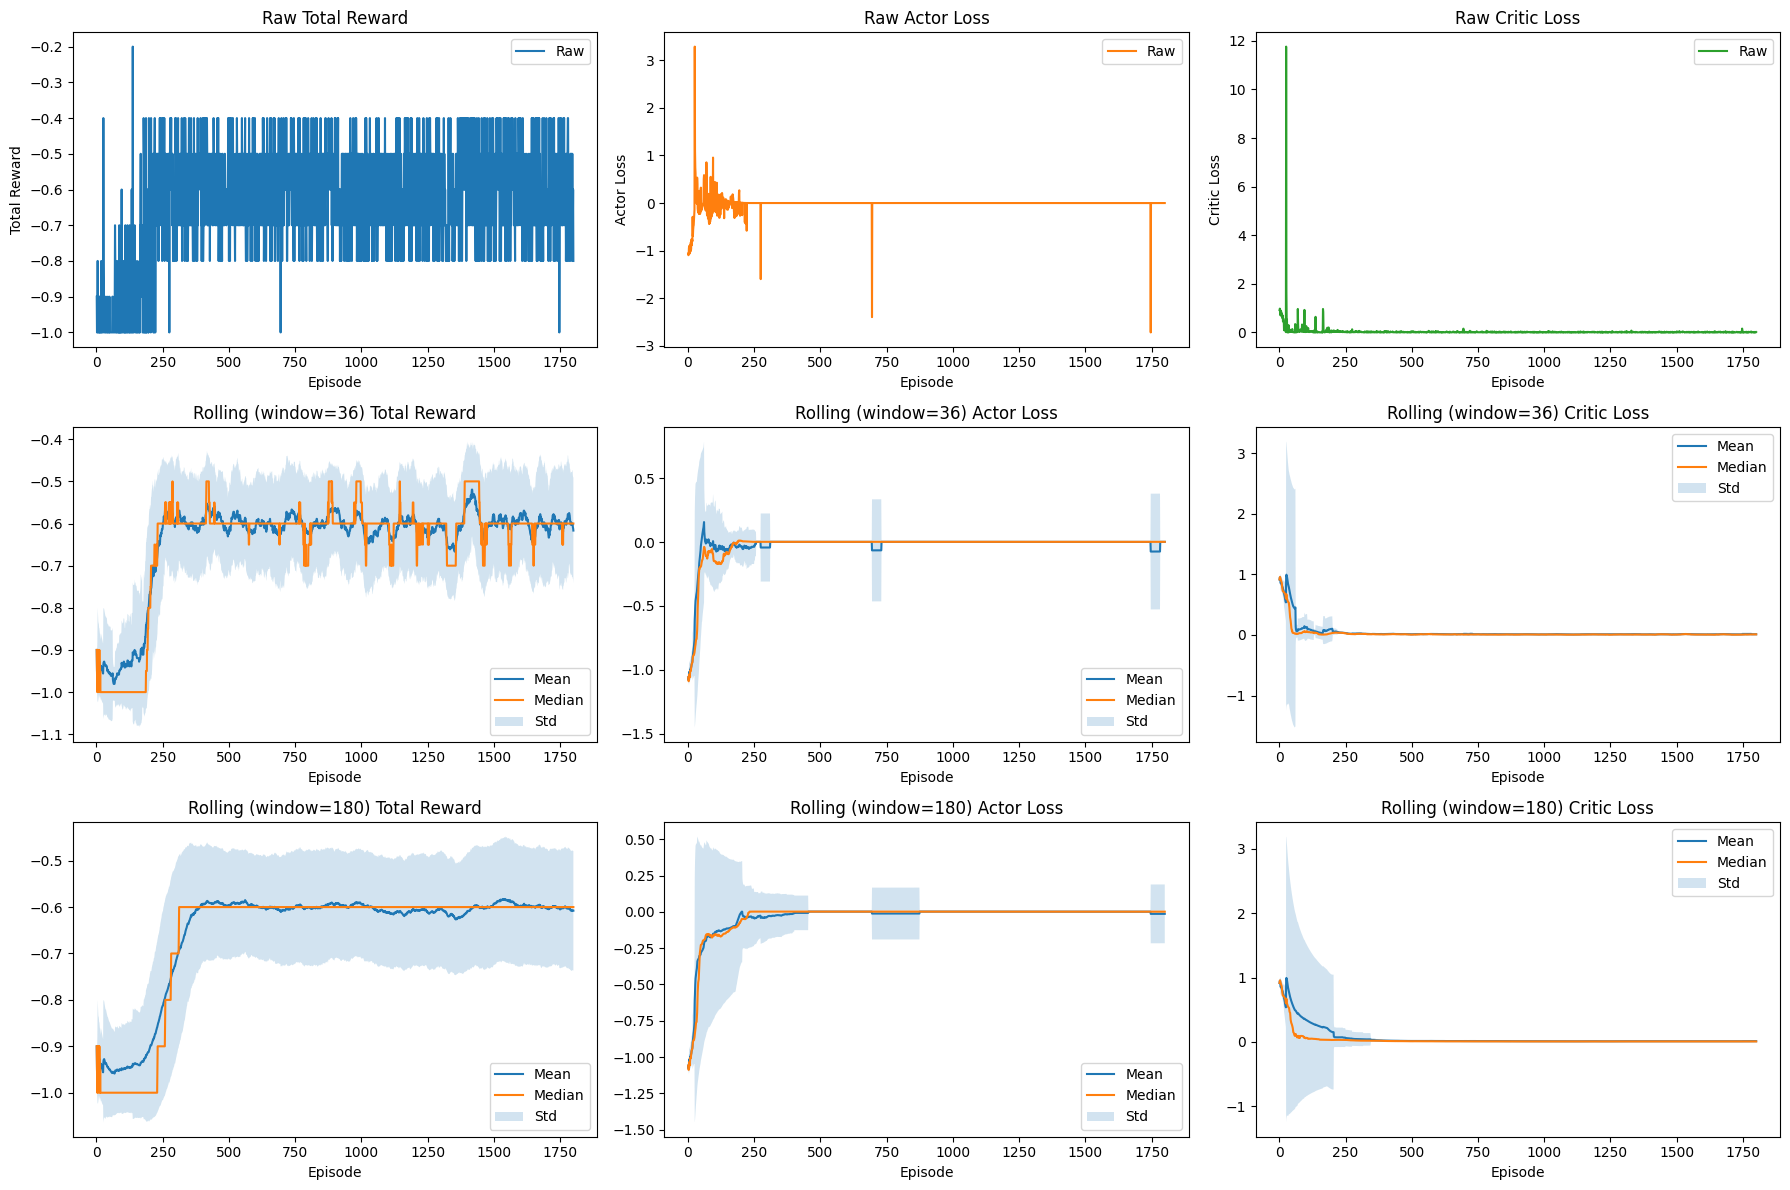

Metrics plot displayed.
Plotting neuron firing rates...


/mnt/c/Users/imcir/Desktop/CIENCIA DATOS/Segundo cuatrimestre/TFM/Código/Modules/helper_functions.py:97: RuntimeWarning: Mean of empty slice
  first_episode = np.nanmean(tensor[:, :, 0], axis=0)
/mnt/c/Users/imcir/Desktop/CIENCIA DATOS/Segundo cuatrimestre/TFM/Código/Modules/helper_functions.py:98: RuntimeWarning: Mean of empty slice
  last_episode = np.nanmean(tensor[:, :, -1], axis=0)


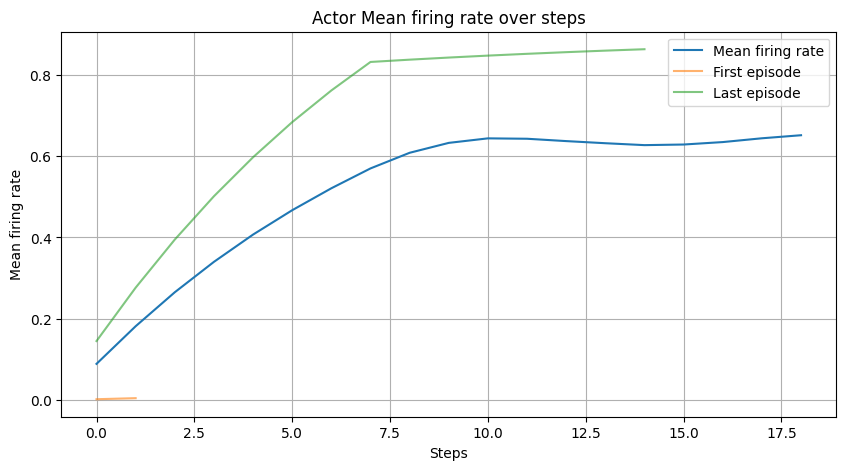

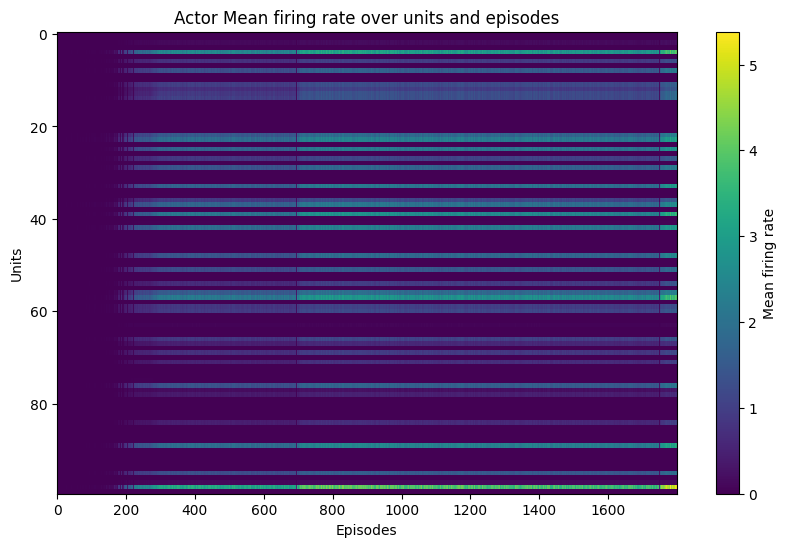

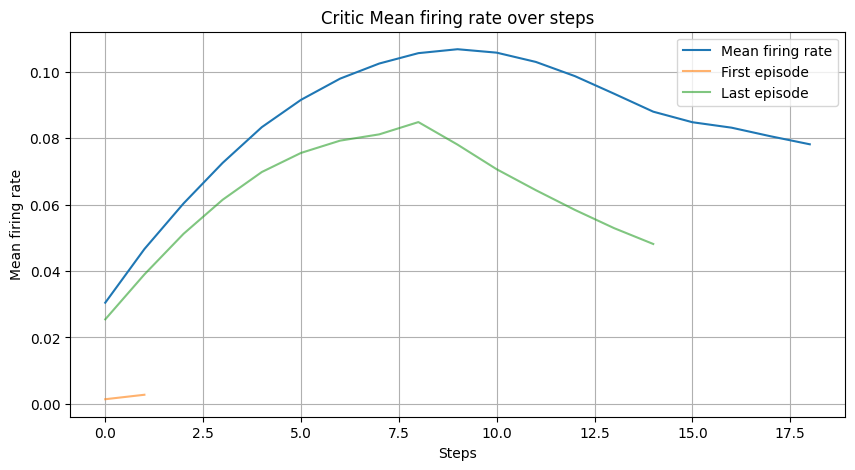

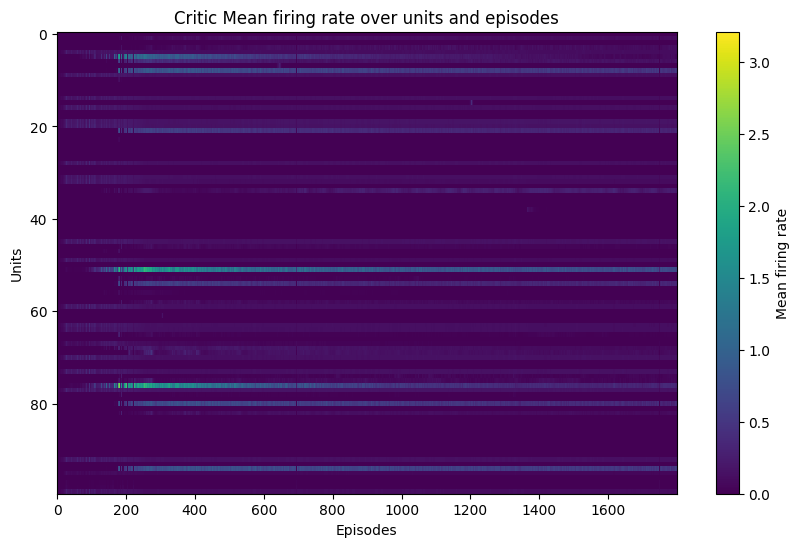

Firing rate plot displayed.

  Plotting Psychometric Curve for this stage...
Cannot plot psychometric curve: No successful trial data provided.
Closing the environment...
Environment closed.


In [3]:
# --- Imports ---
import os
import sys
import gymnasium as gym
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

# --- GPU Configuration ---
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# --- Add Modules directory to Python path ---
module_path = os.path.abspath(os.path.join('.', 'Modules'))

if module_path not in sys.path:
    sys.path.append(module_path)
    print(f"Added '{module_path}' to sys.path")
else:
    print(f"'{module_path}' already in sys.path")

# --- Import custom modules ---
from env_economic_choice import EconomicChoiceEnv
from actor_critic import ActorCriticAgent
from reinforce import train_agent
from helper_functions import plot_metrics, plot_firing_rates, plot_psychometric_curve

# --- Set Random Seeds ---
seed_value = 0
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)

print("Setup Complete.")

# --- Define Paths for Loading/Saving ---
load_weights_path = None
save_weights_path = "saved_models_90/stage_1"

# Ensure save directory exists
save_dir = os.path.dirname(save_weights_path)
if save_dir and not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print(f"Created directory '{save_dir}'")


# --- Training Configuration ---
config = {
    # Environment specific params
    "env_dt_ms": 10,
    "A_to_B_ratio": 2.2,
    "reward_B": 100,
    "abort_penalty": -1.0,
    "input_noise_sigma": 0.0,
    "reward_fixation": 0.1,
    "reward_go_fixation": -0.1,
    "reward_choice_hold": 0.5,
    "duration_params": [50, 30, 70, 70, 30],

    # Agent architecture
    "actor_hidden_size": 100,
    "critic_hidden_size": 100,
    "actor_layers": 1,
    "critic_layers": 1,
    "layer_type": "GRU_modified",
    "actor_prob_connection": 0.1,
    "critic_prob_connection": 1.0,
    "alpha": 0.1,

    # Training hyperparameters
    "actor_lr": 5e-3,
    "critic_lr": 5e-3,
    "num_episodes": 1800,
    "gamma": 1.0,
    "l2_actor": 1e-4,
    "l2_critic": 1e-4,

    # Training process  
    "print_interval": 100,
    "record_history": 1
}

print("Configuration loaded:")
for key, value in config.items():
    print(f"  {key}: {value}")

# --- Environment Setup ---
print("Creating Padoa-Schioppa environment...")
env = EconomicChoiceEnv(
    dt=config["env_dt_ms"],
    A_to_B_ratio=config["A_to_B_ratio"],
    reward_B=config["reward_B"],
    abort_penalty=config["abort_penalty"],
    input_noise_sigma=config["input_noise_sigma"],
    reward_fixation=config["reward_fixation"],
    reward_go_fixation=config["reward_go_fixation"],
    reward_choice_hold=config["reward_choice_hold"],
    duration_params=config["duration_params"]
)

# Get observation and action space sizes from the actual environment instance
obs_size = env.observation_space.shape[0]
act_size = env.action_space.n
print(f"Observation size: {obs_size}, Action size: {act_size}")

initial_obs, initial_info = env.reset(seed=seed_value)
print(f"Environment reset. Initial info: {initial_info}")

# --- Agent Setup ---
print("Initializing Actor-Critic Agent...")
agent = ActorCriticAgent(
    obs_size=obs_size,
    act_size=act_size,
    actor_hidden_size=config["actor_hidden_size"],
    critic_hidden_size=config["critic_hidden_size"],
    actor_layers=config["actor_layers"],
    critic_layers=config["critic_layers"],
    actor_lr=config["actor_lr"],
    critic_lr=config["critic_lr"],
    actor_prob_connection=config["actor_prob_connection"],
    critic_prob_connection=config["critic_prob_connection"],
    layer_type=config["layer_type"],
    alpha=config["alpha"]
)

# Load weights
if load_weights_path:
    print(f"Attempting to load weights from: {load_weights_path}")
    load_successful = agent.load_weights(load_weights_path)
    if not load_successful:
        print(f"WARNING: Failed to load weights. Starting training with initialized weights.")
else:
    print("No weights loaded (load_weights_path is None). Starting from scratch.")

print("Agent Initialized.")

# --- Training ---
print(f"Starting training for {config['num_episodes']} episodes...")

total_rewards_history, actor_loss_history, critic_loss_history, \
actor_firing_rates, critic_firing_rates,  measurements_juices = train_agent(
    env=env,
    agent=agent,
    num_episodes=config["num_episodes"],
    gamma=config["gamma"],
    print_interval=config["print_interval"],
    l2_actor=config["l2_actor"],
    l2_critic=config["l2_critic"],
    record_history=config["record_history"]
)

print("\nTraining finished.")

# Save weights
if save_weights_path:
    print(f"Saving agent weights to: {save_weights_path}")
    agent.save_weights(save_weights_path)
else:
    print("No save path specified (save_weights_path is None). Weights not saved.")

# --- Plot Training Metrics ---
print("Plotting training metrics...")
# Adjust window sizes if needed based on num_episodes
plot_metrics(
    total_rewards_history,
    actor_loss_history,
    critic_loss_history,
    window_1=max(20, config["num_episodes"] // 50),
    window_2=max(50, config["num_episodes"] // 10)
)

print("Metrics plot displayed.")

# --- Plot Firing Rates ---
if actor_firing_rates is not None and critic_firing_rates is not None:
    print("Plotting neuron firing rates...")
    plot_firing_rates(actor_firing_rates, critic_firing_rates)
    print("Firing rate plot displayed.")
# Add checks for partial data as before...
elif actor_firing_rates is not None:
     print("Plotting only Actor firing rates (Critic might be Dense or logging failed)...")
     pass # Add specific plotting if desired
elif critic_firing_rates is not None:
     print("Plotting only Critic firing rates (Actor might be Dense or logging failed)...")
     pass # Add specific plotting if desired
else:
    print("Firing rate data not available (models might be Dense or logging was disabled/failed).")

# --- Plot psychometric curves ---
print("\n  Plotting Psychometric Curve for this stage...")
plot_psychometric_curve(measurements_juices, title=f"Psychometric Curve")

# --- Close the Environment ---
print("Closing the environment...")
env.close()
print("Environment closed.")

#### Smaller learning rate

'/mnt/c/Users/imcir/Desktop/CIENCIA DATOS/Segundo cuatrimestre/TFM/Código/Modules' already in sys.path
Setup Complete.
Configuration loaded:
  env_dt_ms: 10
  A_to_B_ratio: 2.2
  reward_B: 100
  abort_penalty: -1.0
  input_noise_sigma: 0.0
  reward_fixation: 0.1
  reward_go_fixation: -0.1
  reward_choice_hold: 0.5
  duration_params: [50, 30, 70, 70, 30]
  actor_hidden_size: 100
  critic_hidden_size: 100
  actor_layers: 1
  critic_layers: 1
  layer_type: GRU_modified
  actor_prob_connection: 0.1
  critic_prob_connection: 1.0
  alpha: 0.1
  actor_lr: 0.0005
  critic_lr: 0.0005
  num_episodes: 1800
  gamma: 1.0
  l2_actor: 0.0001
  l2_critic: 0.0001
  print_interval: 100
  record_history: 1
Creating Padoa-Schioppa environment...
Observation size: 4, Action size: 3
Environment reset. Initial info: {'step': 0, 'epoch': 'fixation', 'juice_LR': ('B', 'A'), 'offer_BA': (6, 1), 'nL': 6, 'nR': 1, 'rL': 600, 'rR': 220.00000000000003, 'chosen_action': -1, 'choice_time_step': -1, 'is_correct_choice

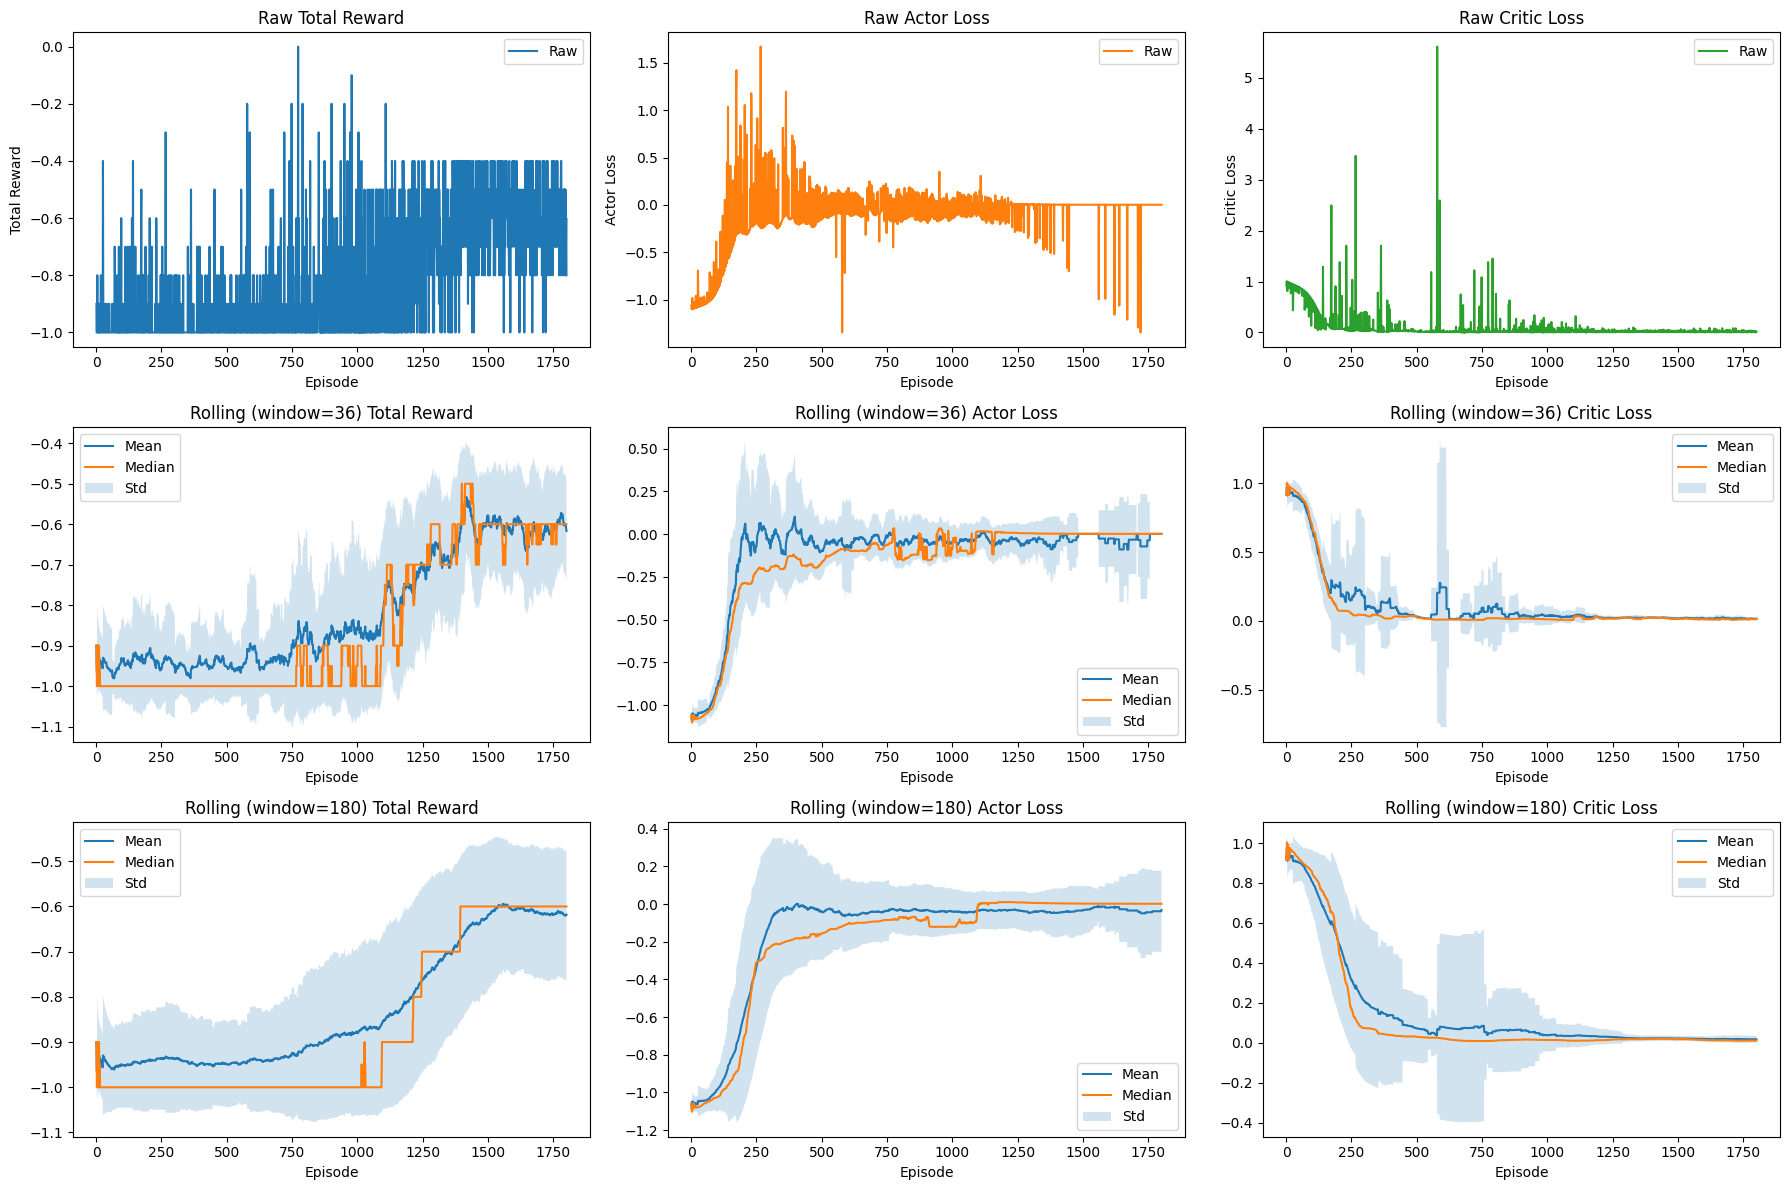

Metrics plot displayed.
Plotting neuron firing rates...


/mnt/c/Users/imcir/Desktop/CIENCIA DATOS/Segundo cuatrimestre/TFM/Código/Modules/helper_functions.py:97: RuntimeWarning: Mean of empty slice
  first_episode = np.nanmean(tensor[:, :, 0], axis=0)
/mnt/c/Users/imcir/Desktop/CIENCIA DATOS/Segundo cuatrimestre/TFM/Código/Modules/helper_functions.py:98: RuntimeWarning: Mean of empty slice
  last_episode = np.nanmean(tensor[:, :, -1], axis=0)


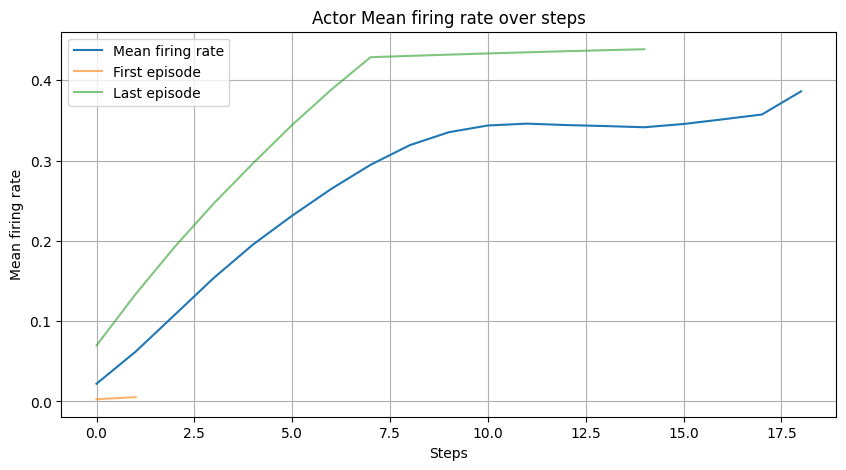

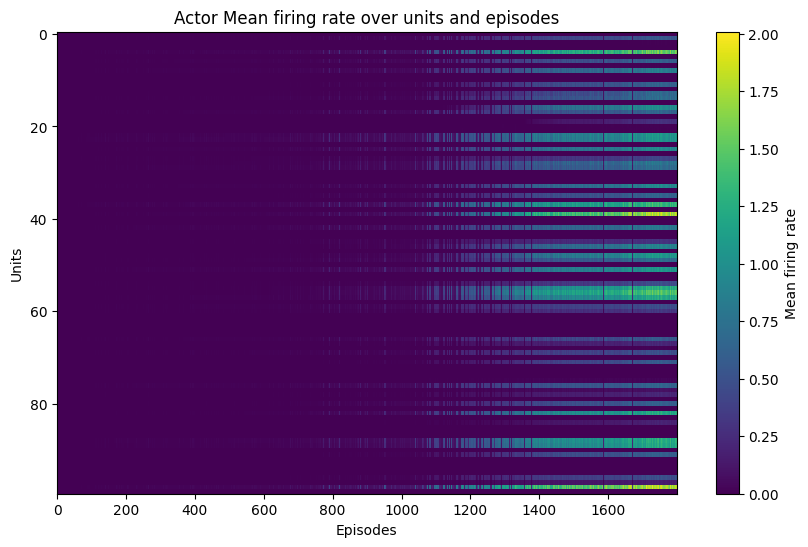

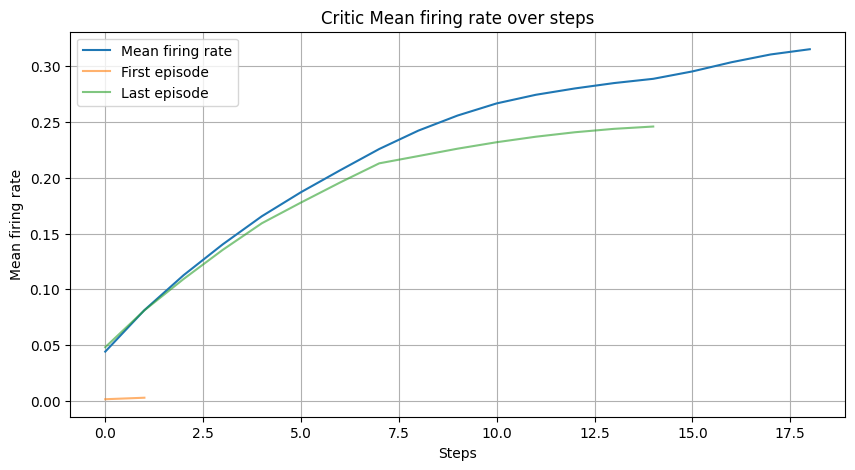

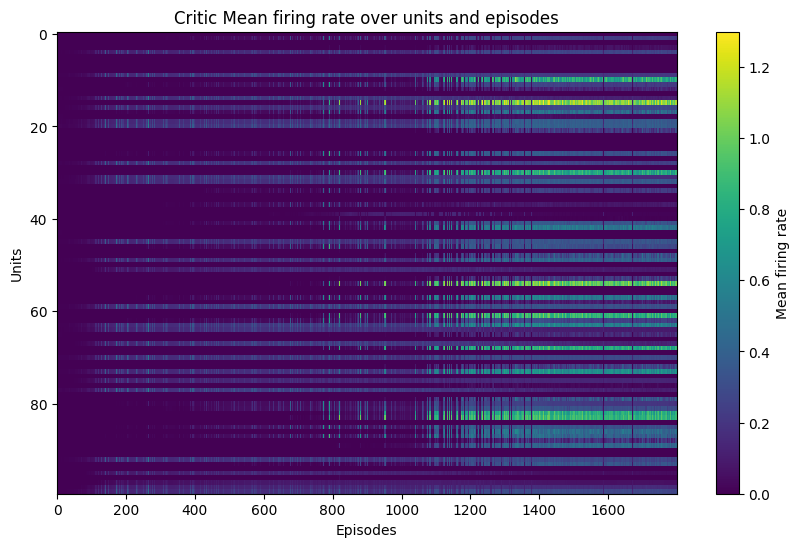

Firing rate plot displayed.

  Plotting Psychometric Curve for this stage...
Cannot plot psychometric curve: No successful trial data provided.
Closing the environment...
Environment closed.


In [5]:
# --- Imports ---
import os
import sys
import gymnasium as gym
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

# --- GPU Configuration ---
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# --- Add Modules directory to Python path ---
module_path = os.path.abspath(os.path.join('.', 'Modules'))

if module_path not in sys.path:
    sys.path.append(module_path)
    print(f"Added '{module_path}' to sys.path")
else:
    print(f"'{module_path}' already in sys.path")

# --- Import custom modules ---
from env_economic_choice import EconomicChoiceEnv
from actor_critic import ActorCriticAgent
from reinforce import train_agent
from helper_functions import plot_metrics, plot_firing_rates, plot_psychometric_curve

# --- Set Random Seeds ---
seed_value = 0
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)

print("Setup Complete.")

# --- Define Paths for Loading/Saving ---
load_weights_path = None
save_weights_path = "saved_models_90/stage_1"

# Ensure save directory exists
save_dir = os.path.dirname(save_weights_path)
if save_dir and not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print(f"Created directory '{save_dir}'")


# --- Training Configuration ---
config = {
    # Environment specific params
    "env_dt_ms": 10,
    "A_to_B_ratio": 2.2,
    "reward_B": 100,
    "abort_penalty": -1.0,
    "input_noise_sigma": 0.0,
    "reward_fixation": 0.1,
    "reward_go_fixation": -0.1,
    "reward_choice_hold": 0.5,
    "duration_params": [50, 30, 70, 70, 30],

    # Agent architecture
    "actor_hidden_size": 100,
    "critic_hidden_size": 100,
    "actor_layers": 1,
    "critic_layers": 1,
    "layer_type": "GRU_modified",
    "actor_prob_connection": 0.1,
    "critic_prob_connection": 1.0,
    "alpha": 0.1,

    # Training hyperparameters
    "actor_lr": 5e-4,
    "critic_lr": 5e-4,
    "num_episodes": 1800,
    "gamma": 1.0,
    "l2_actor": 1e-4,
    "l2_critic": 1e-4,

    # Training process  
    "print_interval": 100,
    "record_history": 1
}

print("Configuration loaded:")
for key, value in config.items():
    print(f"  {key}: {value}")

# --- Environment Setup ---
print("Creating Padoa-Schioppa environment...")
env = EconomicChoiceEnv(
    dt=config["env_dt_ms"],
    A_to_B_ratio=config["A_to_B_ratio"],
    reward_B=config["reward_B"],
    abort_penalty=config["abort_penalty"],
    input_noise_sigma=config["input_noise_sigma"],
    reward_fixation=config["reward_fixation"],
    reward_go_fixation=config["reward_go_fixation"],
    reward_choice_hold=config["reward_choice_hold"],
    duration_params=config["duration_params"]
)

# Get observation and action space sizes from the actual environment instance
obs_size = env.observation_space.shape[0]
act_size = env.action_space.n
print(f"Observation size: {obs_size}, Action size: {act_size}")

initial_obs, initial_info = env.reset(seed=seed_value)
print(f"Environment reset. Initial info: {initial_info}")

# --- Agent Setup ---
print("Initializing Actor-Critic Agent...")
agent = ActorCriticAgent(
    obs_size=obs_size,
    act_size=act_size,
    actor_hidden_size=config["actor_hidden_size"],
    critic_hidden_size=config["critic_hidden_size"],
    actor_layers=config["actor_layers"],
    critic_layers=config["critic_layers"],
    actor_lr=config["actor_lr"],
    critic_lr=config["critic_lr"],
    actor_prob_connection=config["actor_prob_connection"],
    critic_prob_connection=config["critic_prob_connection"],
    layer_type=config["layer_type"],
    alpha=config["alpha"]
)

# Load weights
if load_weights_path:
    print(f"Attempting to load weights from: {load_weights_path}")
    load_successful = agent.load_weights(load_weights_path)
    if not load_successful:
        print(f"WARNING: Failed to load weights. Starting training with initialized weights.")
else:
    print("No weights loaded (load_weights_path is None). Starting from scratch.")

print("Agent Initialized.")

# --- Training ---
print(f"Starting training for {config['num_episodes']} episodes...")

total_rewards_history, actor_loss_history, critic_loss_history, \
actor_firing_rates, critic_firing_rates,  measurements_juices = train_agent(
    env=env,
    agent=agent,
    num_episodes=config["num_episodes"],
    gamma=config["gamma"],
    print_interval=config["print_interval"],
    l2_actor=config["l2_actor"],
    l2_critic=config["l2_critic"],
    record_history=config["record_history"]
)

print("\nTraining finished.")

# Save weights
if save_weights_path:
    print(f"Saving agent weights to: {save_weights_path}")
    agent.save_weights(save_weights_path)
else:
    print("No save path specified (save_weights_path is None). Weights not saved.")

# --- Plot Training Metrics ---
print("Plotting training metrics...")
# Adjust window sizes if needed based on num_episodes
plot_metrics(
    total_rewards_history,
    actor_loss_history,
    critic_loss_history,
    window_1=max(20, config["num_episodes"] // 50),
    window_2=max(50, config["num_episodes"] // 10)
)

print("Metrics plot displayed.")

# --- Plot Firing Rates ---
if actor_firing_rates is not None and critic_firing_rates is not None:
    print("Plotting neuron firing rates...")
    plot_firing_rates(actor_firing_rates, critic_firing_rates)
    print("Firing rate plot displayed.")
# Add checks for partial data as before...
elif actor_firing_rates is not None:
     print("Plotting only Actor firing rates (Critic might be Dense or logging failed)...")
     pass # Add specific plotting if desired
elif critic_firing_rates is not None:
     print("Plotting only Critic firing rates (Actor might be Dense or logging failed)...")
     pass # Add specific plotting if desired
else:
    print("Firing rate data not available (models might be Dense or logging was disabled/failed).")

# --- Plot psychometric curves ---
print("\n  Plotting Psychometric Curve for this stage...")
plot_psychometric_curve(measurements_juices, title=f"Psychometric Curve")

# --- Close the Environment ---
print("Closing the environment...")
env.close()
print("Environment closed.")

'/mnt/c/Users/imcir/Desktop/CIENCIA DATOS/Segundo cuatrimestre/TFM/Código/Modules' already in sys.path
Setup Complete.
Created directory 'saved_models_91'
Configuration loaded:
  env_dt_ms: 10
  A_to_B_ratio: 2.2
  reward_B: 100
  abort_penalty: -1.0
  input_noise_sigma: 0.0
  reward_fixation: 0.1
  reward_go_fixation: -0.1
  reward_choice_hold: 0.5
  duration_params: [50, 30, 70, 70, 30]
  actor_hidden_size: 100
  critic_hidden_size: 100
  actor_layers: 1
  critic_layers: 1
  layer_type: GRU_modified
  actor_prob_connection: 0.1
  critic_prob_connection: 1.0
  alpha: 0.1
  actor_lr: 0.001
  critic_lr: 0.001
  num_episodes: 1800
  gamma: 1.0
  l2_actor: 0.0001
  l2_critic: 0.0001
  print_interval: 100
  record_history: 1
Creating Padoa-Schioppa environment...
Observation size: 4, Action size: 3
Environment reset. Initial info: {'step': 0, 'epoch': 'fixation', 'juice_LR': ('B', 'A'), 'offer_BA': (6, 1), 'nL': 6, 'nR': 1, 'rL': 600, 'rR': 220.00000000000003, 'chosen_action': -1, 'choice_

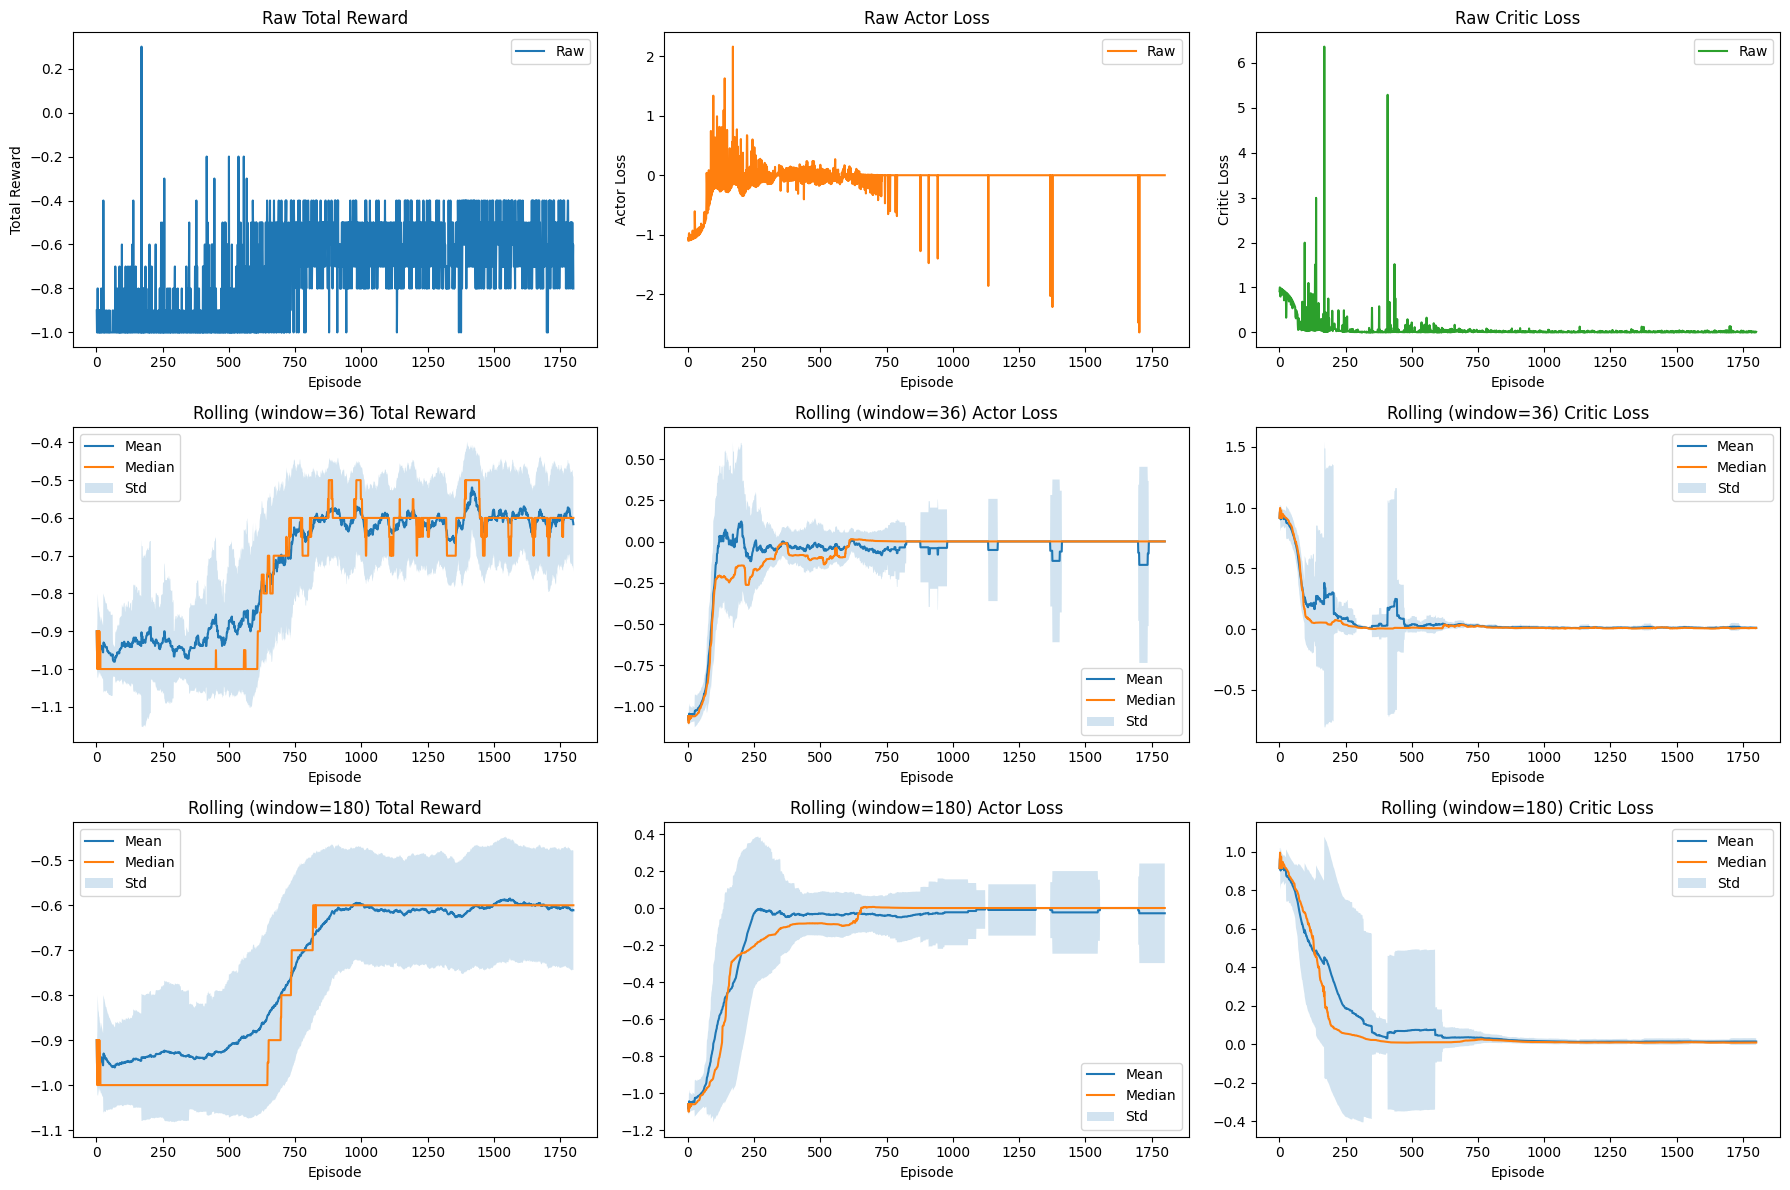

Metrics plot displayed.
Plotting neuron firing rates...


/mnt/c/Users/imcir/Desktop/CIENCIA DATOS/Segundo cuatrimestre/TFM/Código/Modules/helper_functions.py:97: RuntimeWarning: Mean of empty slice
  first_episode = np.nanmean(tensor[:, :, 0], axis=0)
/mnt/c/Users/imcir/Desktop/CIENCIA DATOS/Segundo cuatrimestre/TFM/Código/Modules/helper_functions.py:98: RuntimeWarning: Mean of empty slice
  last_episode = np.nanmean(tensor[:, :, -1], axis=0)


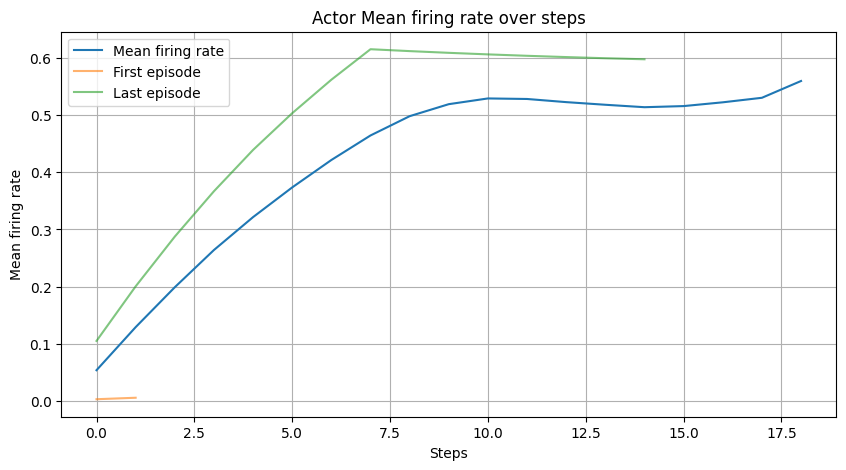

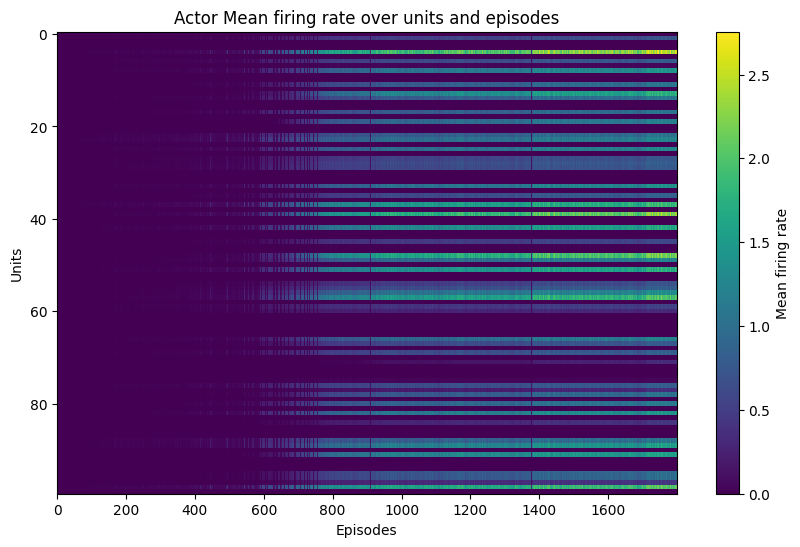

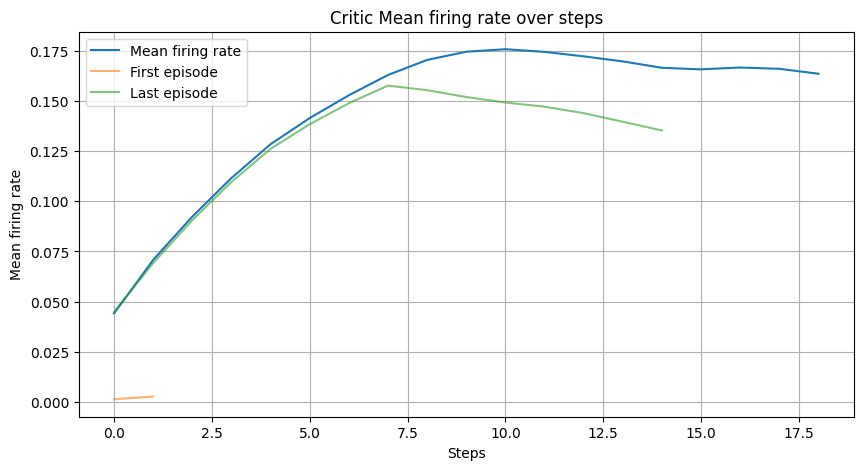

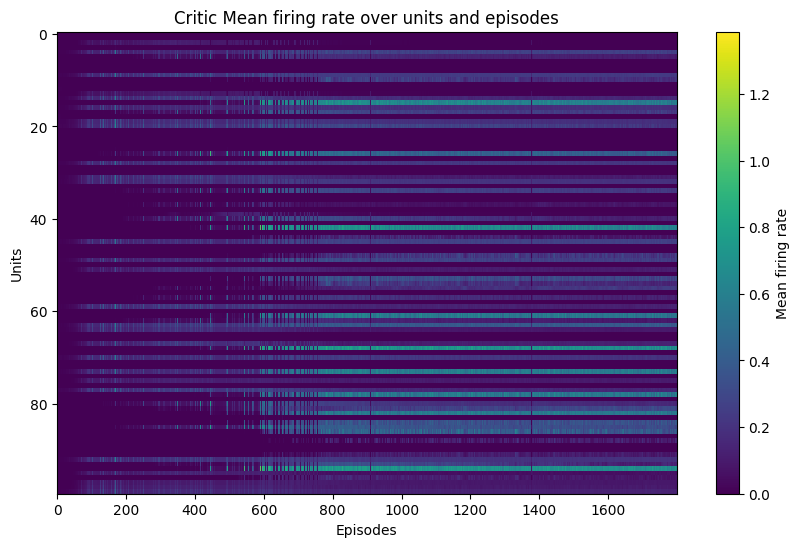

Firing rate plot displayed.

  Plotting Psychometric Curve for this stage...
Cannot plot psychometric curve: No successful trial data provided.
Closing the environment...
Environment closed.


In [6]:
# --- Imports ---
import os
import sys
import gymnasium as gym
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

# --- GPU Configuration ---
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# --- Add Modules directory to Python path ---
module_path = os.path.abspath(os.path.join('.', 'Modules'))

if module_path not in sys.path:
    sys.path.append(module_path)
    print(f"Added '{module_path}' to sys.path")
else:
    print(f"'{module_path}' already in sys.path")

# --- Import custom modules ---
from env_economic_choice import EconomicChoiceEnv
from actor_critic import ActorCriticAgent
from reinforce import train_agent
from helper_functions import plot_metrics, plot_firing_rates, plot_psychometric_curve

# --- Set Random Seeds ---
seed_value = 0
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)

print("Setup Complete.")

# --- Define Paths for Loading/Saving ---
load_weights_path = None
save_weights_path = "saved_models_91/stage_1"

# Ensure save directory exists
save_dir = os.path.dirname(save_weights_path)
if save_dir and not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print(f"Created directory '{save_dir}'")


# --- Training Configuration ---
config = {
    # Environment specific params
    "env_dt_ms": 10,
    "A_to_B_ratio": 2.2,
    "reward_B": 100,
    "abort_penalty": -1.0,
    "input_noise_sigma": 0.0,
    "reward_fixation": 0.1,
    "reward_go_fixation": -0.1,
    "reward_choice_hold": 0.5,
    "duration_params": [50, 30, 70, 70, 30],

    # Agent architecture
    "actor_hidden_size": 100,
    "critic_hidden_size": 100,
    "actor_layers": 1,
    "critic_layers": 1,
    "layer_type": "GRU_modified",
    "actor_prob_connection": 0.1,
    "critic_prob_connection": 1.0,
    "alpha": 0.1,

    # Training hyperparameters
    "actor_lr": 1e-3,
    "critic_lr": 1e-3,
    "num_episodes": 1800,
    "gamma": 1.0,
    "l2_actor": 1e-4,
    "l2_critic": 1e-4,

    # Training process  
    "print_interval": 100,
    "record_history": 1
}

print("Configuration loaded:")
for key, value in config.items():
    print(f"  {key}: {value}")

# --- Environment Setup ---
print("Creating Padoa-Schioppa environment...")
env = EconomicChoiceEnv(
    dt=config["env_dt_ms"],
    A_to_B_ratio=config["A_to_B_ratio"],
    reward_B=config["reward_B"],
    abort_penalty=config["abort_penalty"],
    input_noise_sigma=config["input_noise_sigma"],
    reward_fixation=config["reward_fixation"],
    reward_go_fixation=config["reward_go_fixation"],
    reward_choice_hold=config["reward_choice_hold"],
    duration_params=config["duration_params"]
)

# Get observation and action space sizes from the actual environment instance
obs_size = env.observation_space.shape[0]
act_size = env.action_space.n
print(f"Observation size: {obs_size}, Action size: {act_size}")

initial_obs, initial_info = env.reset(seed=seed_value)
print(f"Environment reset. Initial info: {initial_info}")

# --- Agent Setup ---
print("Initializing Actor-Critic Agent...")
agent = ActorCriticAgent(
    obs_size=obs_size,
    act_size=act_size,
    actor_hidden_size=config["actor_hidden_size"],
    critic_hidden_size=config["critic_hidden_size"],
    actor_layers=config["actor_layers"],
    critic_layers=config["critic_layers"],
    actor_lr=config["actor_lr"],
    critic_lr=config["critic_lr"],
    actor_prob_connection=config["actor_prob_connection"],
    critic_prob_connection=config["critic_prob_connection"],
    layer_type=config["layer_type"],
    alpha=config["alpha"]
)

# Load weights
if load_weights_path:
    print(f"Attempting to load weights from: {load_weights_path}")
    load_successful = agent.load_weights(load_weights_path)
    if not load_successful:
        print(f"WARNING: Failed to load weights. Starting training with initialized weights.")
else:
    print("No weights loaded (load_weights_path is None). Starting from scratch.")

print("Agent Initialized.")

# --- Training ---
print(f"Starting training for {config['num_episodes']} episodes...")

total_rewards_history, actor_loss_history, critic_loss_history, \
actor_firing_rates, critic_firing_rates,  measurements_juices = train_agent(
    env=env,
    agent=agent,
    num_episodes=config["num_episodes"],
    gamma=config["gamma"],
    print_interval=config["print_interval"],
    l2_actor=config["l2_actor"],
    l2_critic=config["l2_critic"],
    record_history=config["record_history"]
)

print("\nTraining finished.")

# Save weights
if save_weights_path:
    print(f"Saving agent weights to: {save_weights_path}")
    agent.save_weights(save_weights_path)
else:
    print("No save path specified (save_weights_path is None). Weights not saved.")

# --- Plot Training Metrics ---
print("Plotting training metrics...")
# Adjust window sizes if needed based on num_episodes
plot_metrics(
    total_rewards_history,
    actor_loss_history,
    critic_loss_history,
    window_1=max(20, config["num_episodes"] // 50),
    window_2=max(50, config["num_episodes"] // 10)
)

print("Metrics plot displayed.")

# --- Plot Firing Rates ---
if actor_firing_rates is not None and critic_firing_rates is not None:
    print("Plotting neuron firing rates...")
    plot_firing_rates(actor_firing_rates, critic_firing_rates)
    print("Firing rate plot displayed.")
# Add checks for partial data as before...
elif actor_firing_rates is not None:
     print("Plotting only Actor firing rates (Critic might be Dense or logging failed)...")
     pass # Add specific plotting if desired
elif critic_firing_rates is not None:
     print("Plotting only Critic firing rates (Actor might be Dense or logging failed)...")
     pass # Add specific plotting if desired
else:
    print("Firing rate data not available (models might be Dense or logging was disabled/failed).")

# --- Plot psychometric curves ---
print("\n  Plotting Psychometric Curve for this stage...")
plot_psychometric_curve(measurements_juices, title=f"Psychometric Curve")

# --- Close the Environment ---
print("Closing the environment...")
env.close()
print("Environment closed.")

#### Reward + exploration for choosing

'/mnt/c/Users/imcir/Desktop/CIENCIA DATOS/Segundo cuatrimestre/TFM/Código/Modules' already in sys.path
Setup Complete.
Configuration loaded:
  env_dt_ms: 10
  A_to_B_ratio: 2.2
  reward_B: 1
  abort_penalty: -0.1
  input_noise_sigma: 0.0
  reward_fixation: 0.01
  reward_go_fixation: -0.05
  reward_choice_hold: 0.05
  duration_params: [50, 30, 70, 70, 30]
  actor_hidden_size: 100
  critic_hidden_size: 100
  actor_layers: 1
  critic_layers: 1
  layer_type: GRU_modified
  actor_prob_connection: 0.1
  critic_prob_connection: 1.0
  alpha: 0.1
  actor_lr: 0.001
  critic_lr: 0.001
  num_episodes: 1800
  gamma: 0.99
  l2_actor: 0.0001
  l2_critic: 0.0001
  print_interval: 100
  record_history: 1
Creating Padoa-Schioppa environment...
Observation size: 4, Action size: 3
Environment reset. Initial info: {'step': 0, 'epoch': 'fixation', 'juice_LR': ('B', 'A'), 'offer_BA': (6, 1), 'nL': 6, 'nR': 1, 'rL': 6, 'rR': 2.2, 'chosen_action': -1, 'choice_time_step': -1, 'is_correct_choice': None, 'A_to_B_

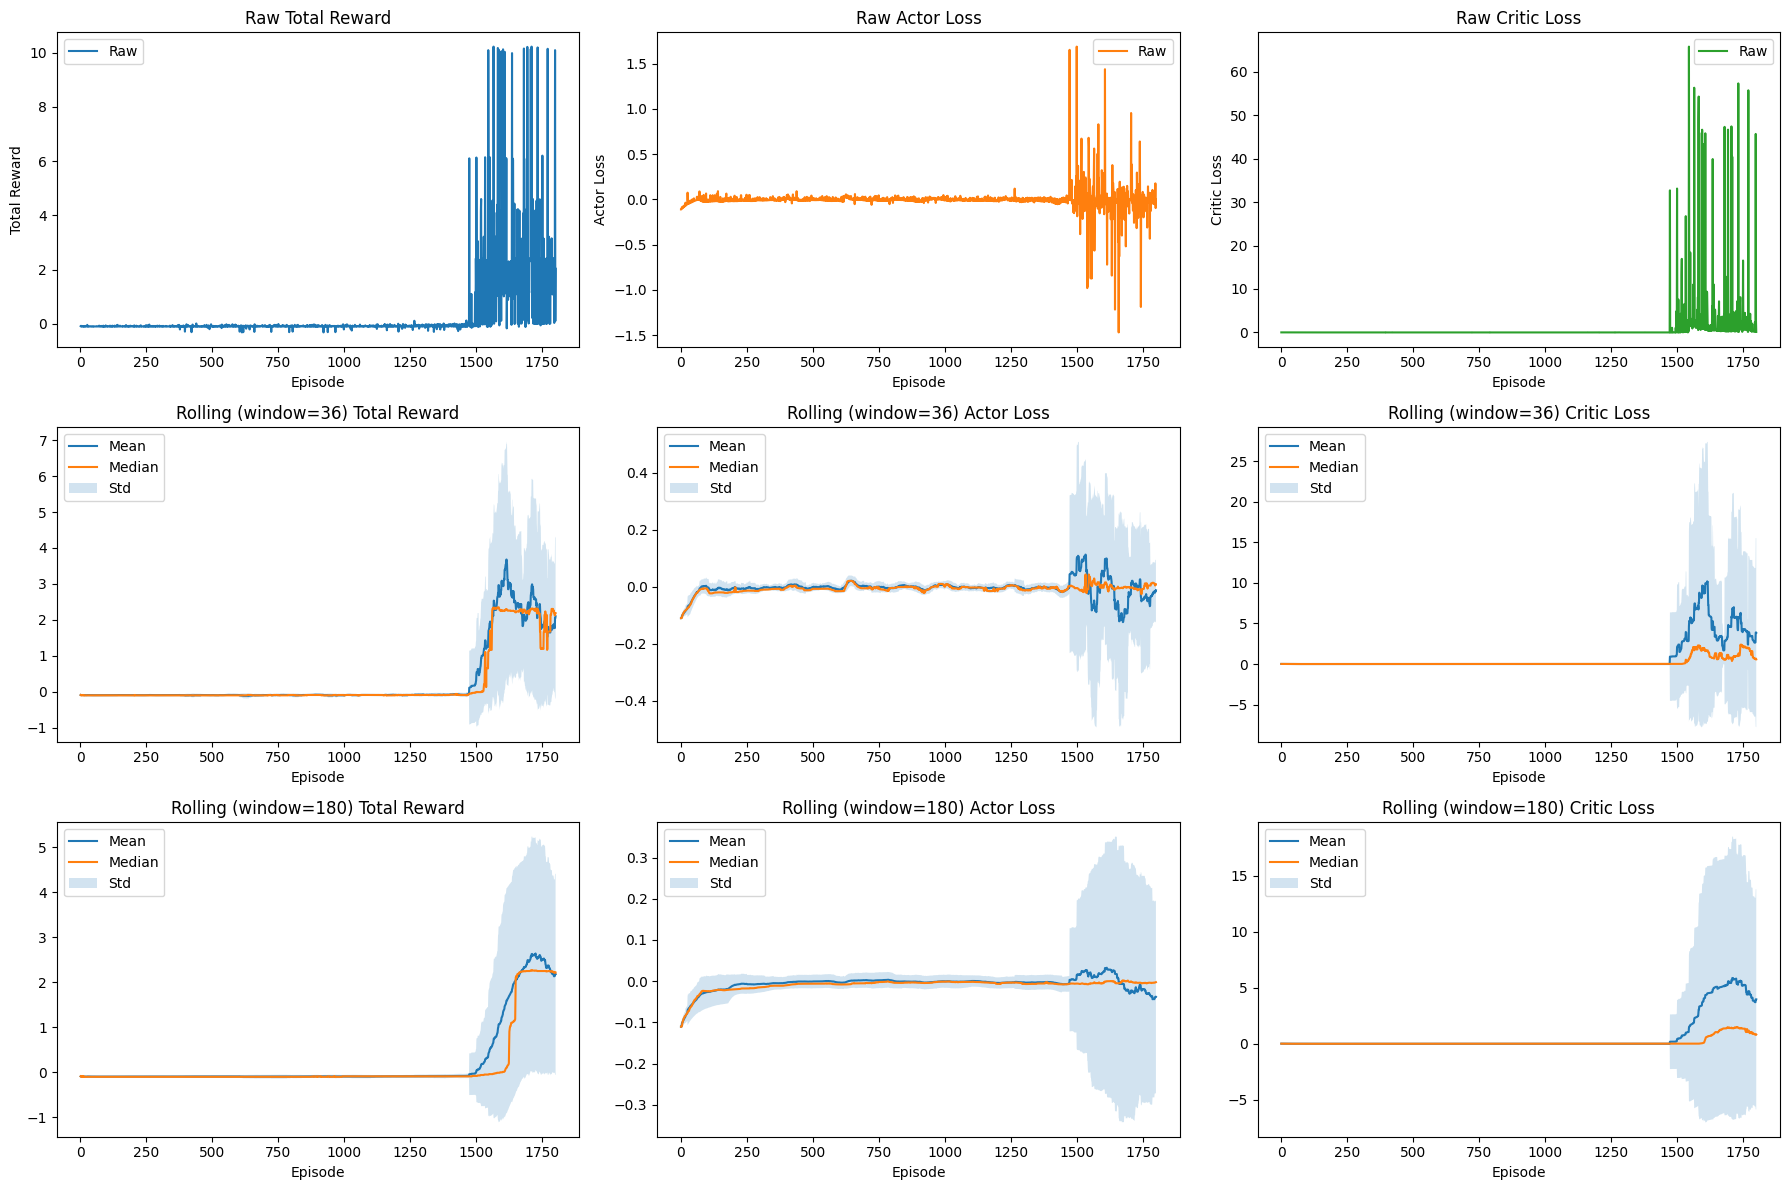

Metrics plot displayed.
Plotting neuron firing rates...


/mnt/c/Users/imcir/Desktop/CIENCIA DATOS/Segundo cuatrimestre/TFM/Código/Modules/helper_functions.py:97: RuntimeWarning: Mean of empty slice
  first_episode = np.nanmean(tensor[:, :, 0], axis=0)
/mnt/c/Users/imcir/Desktop/CIENCIA DATOS/Segundo cuatrimestre/TFM/Código/Modules/helper_functions.py:98: RuntimeWarning: Mean of empty slice
  last_episode = np.nanmean(tensor[:, :, -1], axis=0)


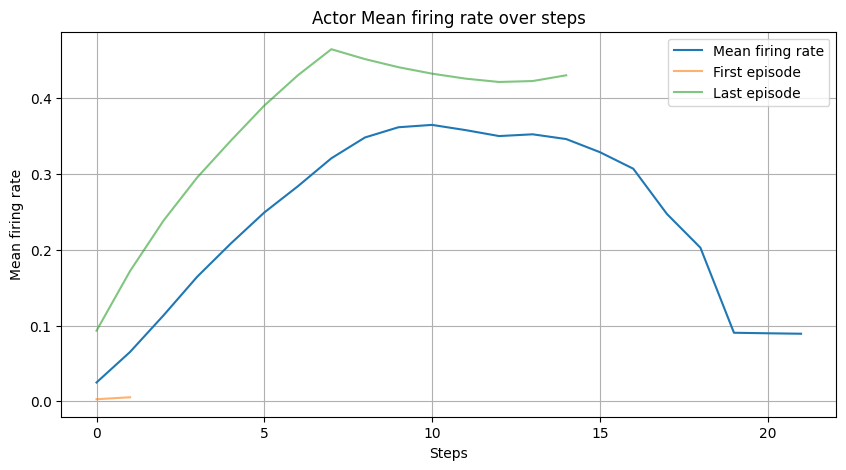

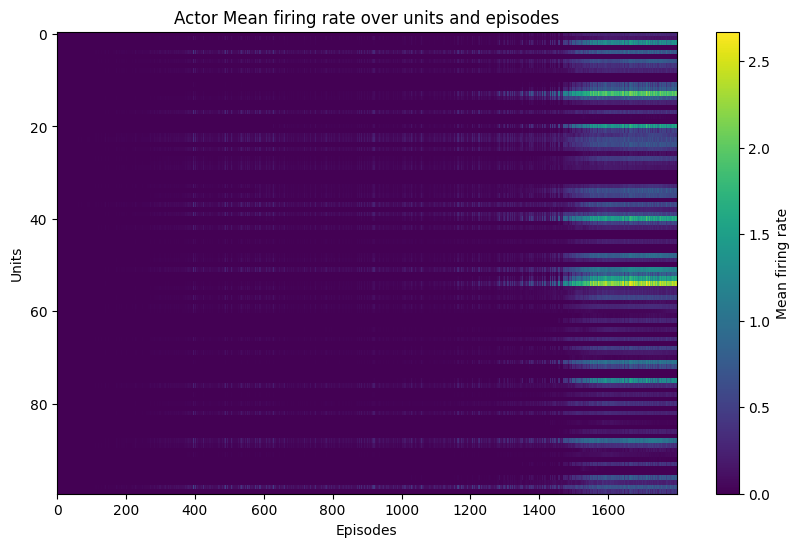

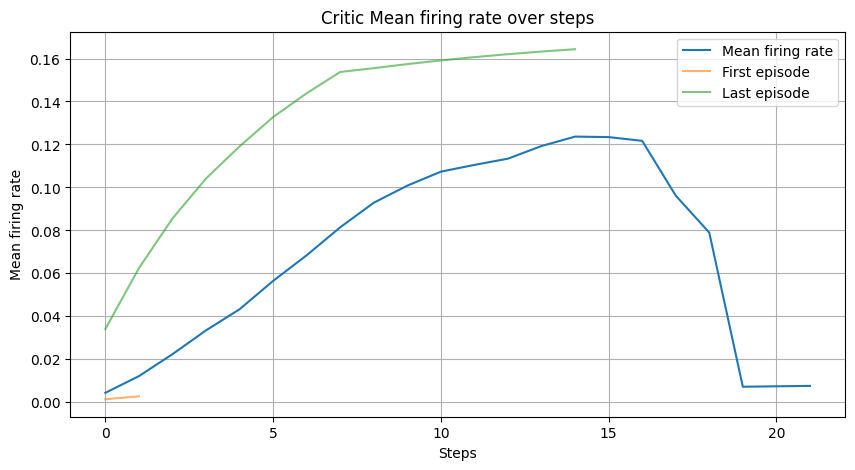

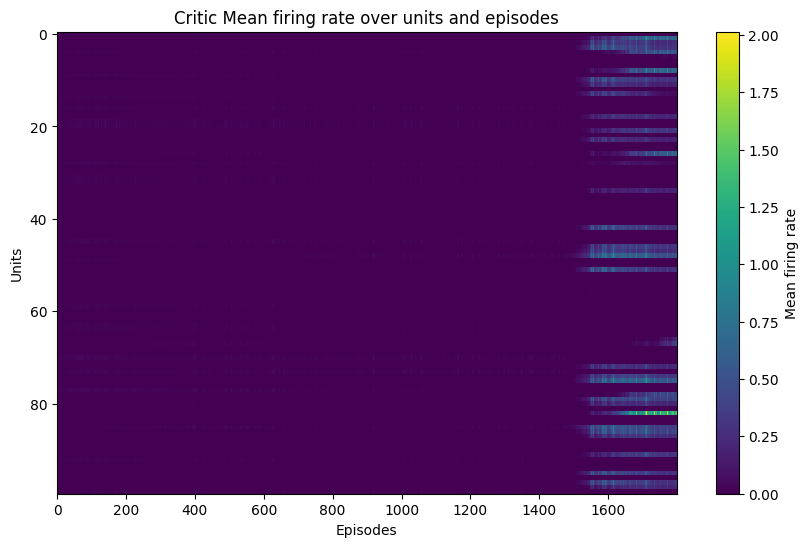

Firing rate plot displayed.

  Plotting Psychometric Curve for this stage...


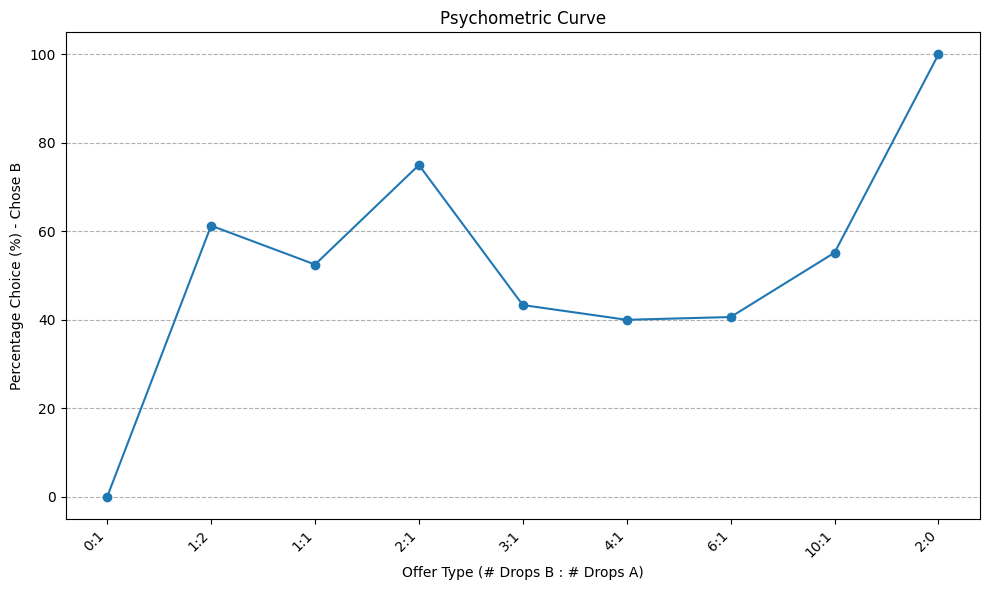

Closing the environment...
Environment closed.


In [8]:
# --- Imports ---
import os
import sys
import gymnasium as gym
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

# --- GPU Configuration ---
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# --- Add Modules directory to Python path ---
module_path = os.path.abspath(os.path.join('.', 'Modules'))

if module_path not in sys.path:
    sys.path.append(module_path)
    print(f"Added '{module_path}' to sys.path")
else:
    print(f"'{module_path}' already in sys.path")

# --- Import custom modules ---
from env_economic_choice import EconomicChoiceEnv
from actor_critic import ActorCriticAgent
from reinforce import train_agent
from helper_functions import plot_metrics, plot_firing_rates, plot_psychometric_curve

# --- Set Random Seeds ---
seed_value = 0
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)

print("Setup Complete.")

# --- Define Paths for Loading/Saving ---
load_weights_path = None
save_weights_path = "saved_models_91/stage_2"

# Ensure save directory exists
save_dir = os.path.dirname(save_weights_path)
if save_dir and not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print(f"Created directory '{save_dir}'")


# --- Training Configuration ---
config = {
    # Environment specific params
    "env_dt_ms": 10,
    "A_to_B_ratio": 2.2,
    "reward_B": 1,
    "abort_penalty": -0.1,
    "input_noise_sigma": 0.0,
    "reward_fixation": 0.01,
    "reward_go_fixation": -0.05,
    "reward_choice_hold": 0.05,
    "duration_params": [50, 30, 70, 70, 30],

    # Agent architecture
    "actor_hidden_size": 100,
    "critic_hidden_size": 100,
    "actor_layers": 1,
    "critic_layers": 1,
    "layer_type": "GRU_modified",
    "actor_prob_connection": 0.1,
    "critic_prob_connection": 1.0,
    "alpha": 0.1,

    # Training hyperparameters
    "actor_lr": 1e-3,
    "critic_lr": 1e-3,
    "num_episodes": 1800,
    "gamma": 0.99,
    "l2_actor": 1e-4,
    "l2_critic": 1e-4,

    # Training process  
    "print_interval": 100,
    "record_history": 1
}

print("Configuration loaded:")
for key, value in config.items():
    print(f"  {key}: {value}")

# --- Environment Setup ---
print("Creating Padoa-Schioppa environment...")
env = EconomicChoiceEnv(
    dt=config["env_dt_ms"],
    A_to_B_ratio=config["A_to_B_ratio"],
    reward_B=config["reward_B"],
    abort_penalty=config["abort_penalty"],
    input_noise_sigma=config["input_noise_sigma"],
    reward_fixation=config["reward_fixation"],
    reward_go_fixation=config["reward_go_fixation"],
    reward_choice_hold=config["reward_choice_hold"],
    duration_params=config["duration_params"]
)

# Get observation and action space sizes from the actual environment instance
obs_size = env.observation_space.shape[0]
act_size = env.action_space.n
print(f"Observation size: {obs_size}, Action size: {act_size}")

initial_obs, initial_info = env.reset(seed=seed_value)
print(f"Environment reset. Initial info: {initial_info}")

# --- Agent Setup ---
print("Initializing Actor-Critic Agent...")
agent = ActorCriticAgent(
    obs_size=obs_size,
    act_size=act_size,
    actor_hidden_size=config["actor_hidden_size"],
    critic_hidden_size=config["critic_hidden_size"],
    actor_layers=config["actor_layers"],
    critic_layers=config["critic_layers"],
    actor_lr=config["actor_lr"],
    critic_lr=config["critic_lr"],
    actor_prob_connection=config["actor_prob_connection"],
    critic_prob_connection=config["critic_prob_connection"],
    layer_type=config["layer_type"],
    alpha=config["alpha"]
)

# Load weights
if load_weights_path:
    print(f"Attempting to load weights from: {load_weights_path}")
    load_successful = agent.load_weights(load_weights_path)
    if not load_successful:
        print(f"WARNING: Failed to load weights. Starting training with initialized weights.")
else:
    print("No weights loaded (load_weights_path is None). Starting from scratch.")

print("Agent Initialized.")

# --- Training ---
print(f"Starting training for {config['num_episodes']} episodes...")

total_rewards_history, actor_loss_history, critic_loss_history, \
actor_firing_rates, critic_firing_rates,  measurements_juices = train_agent(
    env=env,
    agent=agent,
    num_episodes=config["num_episodes"],
    gamma=config["gamma"],
    print_interval=config["print_interval"],
    l2_actor=config["l2_actor"],
    l2_critic=config["l2_critic"],
    record_history=config["record_history"]
)

print("\nTraining finished.")

# Save weights
if save_weights_path:
    print(f"Saving agent weights to: {save_weights_path}")
    agent.save_weights(save_weights_path)
else:
    print("No save path specified (save_weights_path is None). Weights not saved.")

# --- Plot Training Metrics ---
print("Plotting training metrics...")
# Adjust window sizes if needed based on num_episodes
plot_metrics(
    total_rewards_history,
    actor_loss_history,
    critic_loss_history,
    window_1=max(20, config["num_episodes"] // 50),
    window_2=max(50, config["num_episodes"] // 10)
)

print("Metrics plot displayed.")

# --- Plot Firing Rates ---
if actor_firing_rates is not None and critic_firing_rates is not None:
    print("Plotting neuron firing rates...")
    plot_firing_rates(actor_firing_rates, critic_firing_rates)
    print("Firing rate plot displayed.")
# Add checks for partial data as before...
elif actor_firing_rates is not None:
     print("Plotting only Actor firing rates (Critic might be Dense or logging failed)...")
     pass # Add specific plotting if desired
elif critic_firing_rates is not None:
     print("Plotting only Critic firing rates (Actor might be Dense or logging failed)...")
     pass # Add specific plotting if desired
else:
    print("Firing rate data not available (models might be Dense or logging was disabled/failed).")

# --- Plot psychometric curves ---
print("\n  Plotting Psychometric Curve for this stage...")
plot_psychometric_curve(measurements_juices, title=f"Psychometric Curve")

# --- Close the Environment ---
print("Closing the environment...")
env.close()
print("Environment closed.")

'/mnt/c/Users/imcir/Desktop/CIENCIA DATOS/Segundo cuatrimestre/TFM/Código/Modules' already in sys.path
Setup Complete.
Configuration loaded:
  env_dt_ms: 10
  A_to_B_ratio: 2.2
  reward_B: 1
  abort_penalty: -0.1
  input_noise_sigma: 0.0
  reward_fixation: 0.01
  reward_go_fixation: -0.05
  reward_choice_hold: 0.05
  duration_params: [50, 30, 70, 70, 30]
  actor_hidden_size: 100
  critic_hidden_size: 100
  actor_layers: 1
  critic_layers: 1
  layer_type: GRU_modified
  actor_prob_connection: 0.1
  critic_prob_connection: 1.0
  alpha: 0.1
  actor_lr: 0.001
  critic_lr: 0.001
  num_episodes: 5000
  gamma: 0.99
  l2_actor: 0.0001
  l2_critic: 0.0001
  print_interval: 100
  record_history: 1
Creating Padoa-Schioppa environment...
Observation size: 4, Action size: 3
Environment reset. Initial info: {'step': 0, 'epoch': 'fixation', 'juice_LR': ('B', 'A'), 'offer_BA': (6, 1), 'nL': 6, 'nR': 1, 'rL': 6, 'rR': 2.2, 'chosen_action': -1, 'choice_time_step': -1, 'is_correct_choice': None, 'A_to_B_

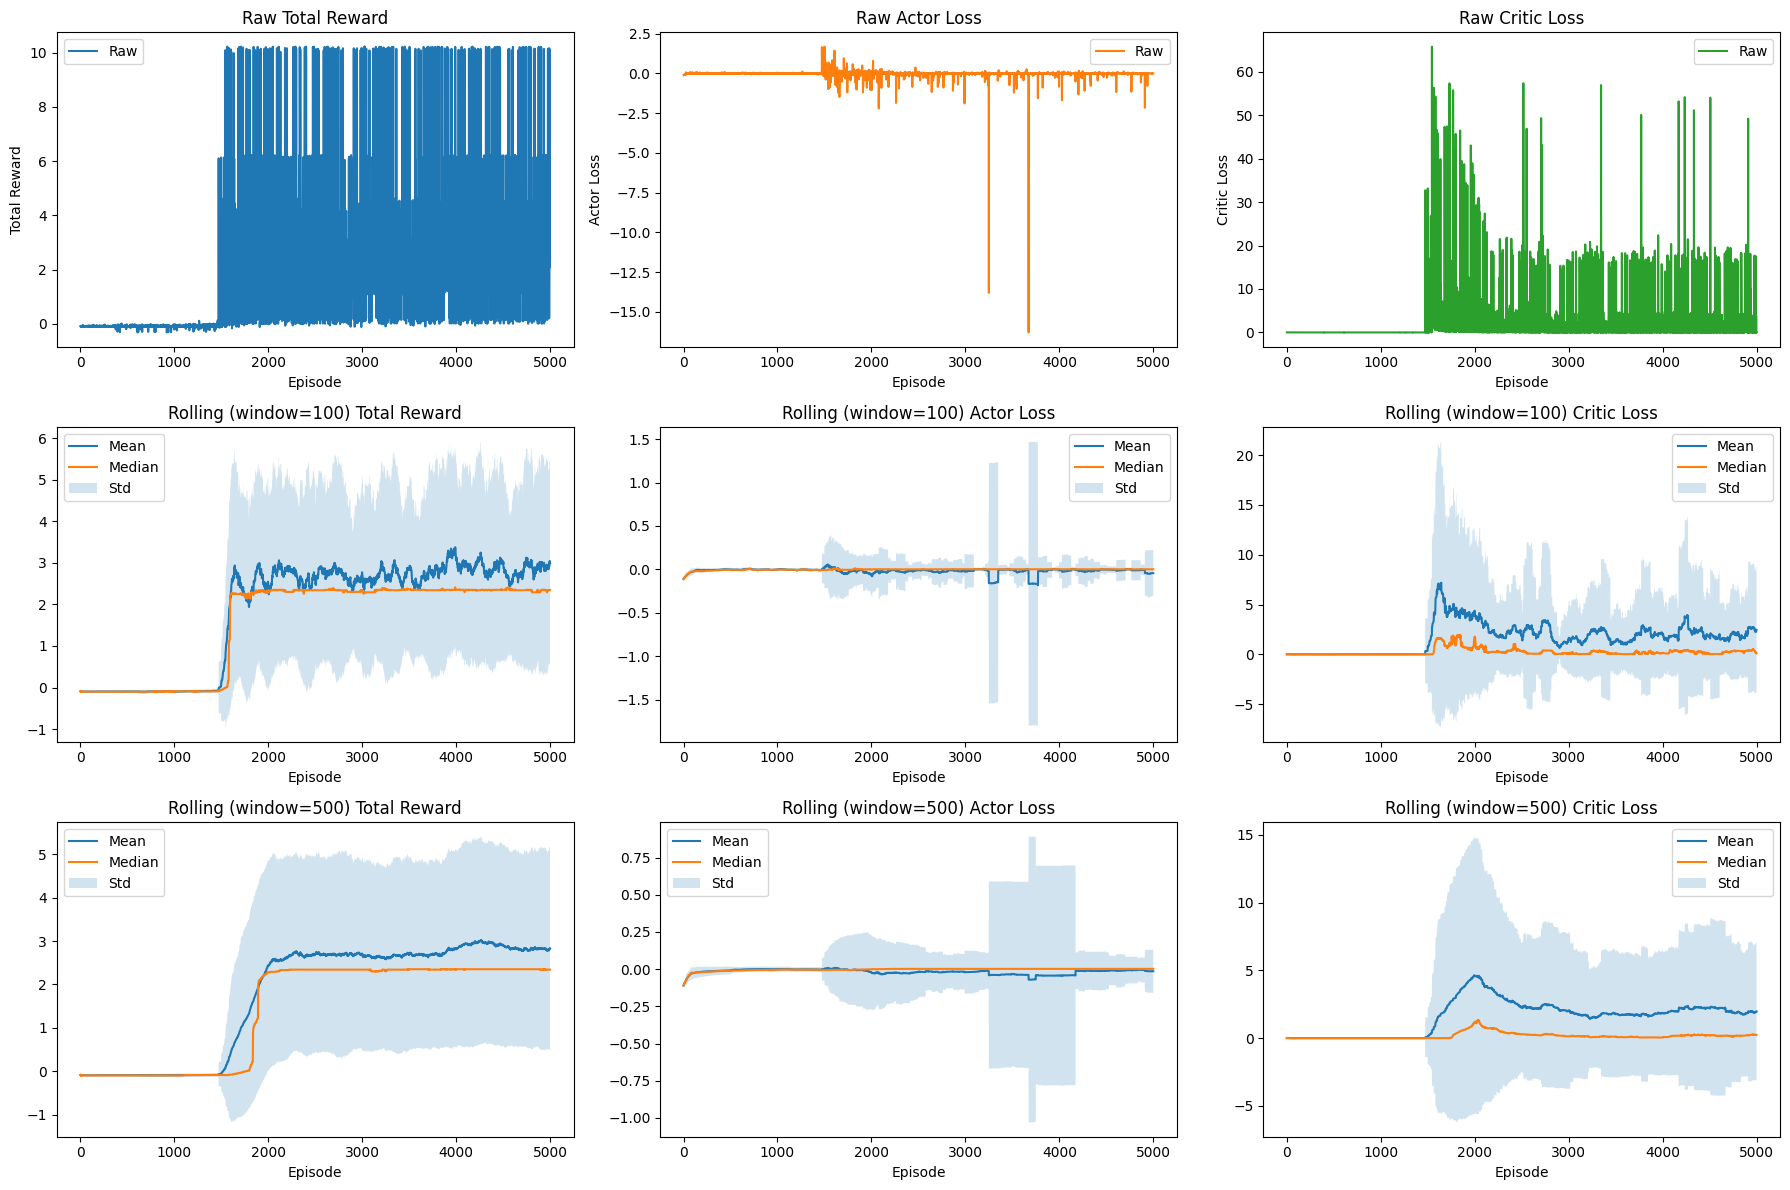

Metrics plot displayed.
Plotting neuron firing rates...


/mnt/c/Users/imcir/Desktop/CIENCIA DATOS/Segundo cuatrimestre/TFM/Código/Modules/helper_functions.py:97: RuntimeWarning: Mean of empty slice
  first_episode = np.nanmean(tensor[:, :, 0], axis=0)
/mnt/c/Users/imcir/Desktop/CIENCIA DATOS/Segundo cuatrimestre/TFM/Código/Modules/helper_functions.py:98: RuntimeWarning: Mean of empty slice
  last_episode = np.nanmean(tensor[:, :, -1], axis=0)


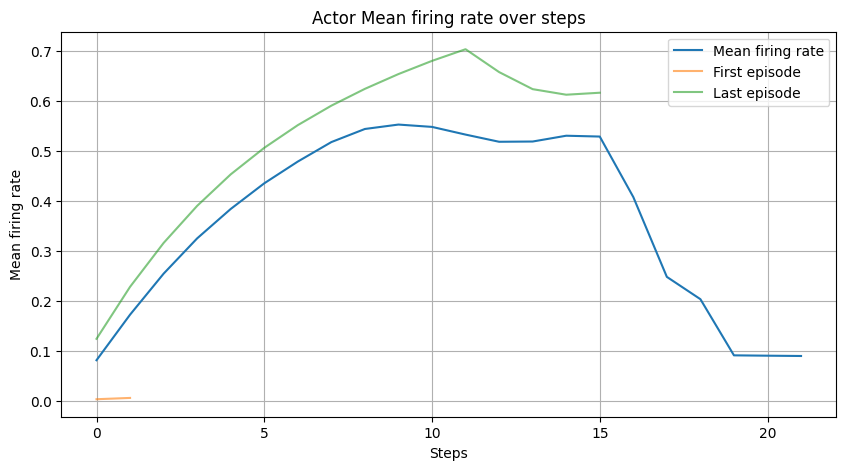

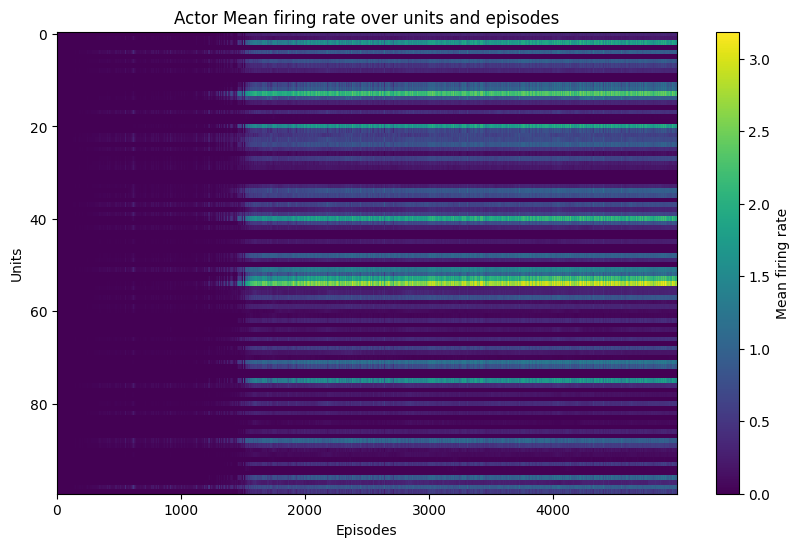

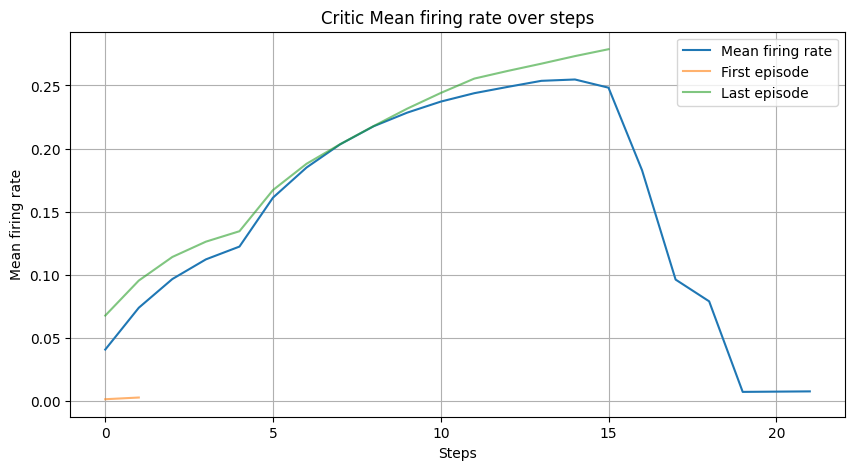

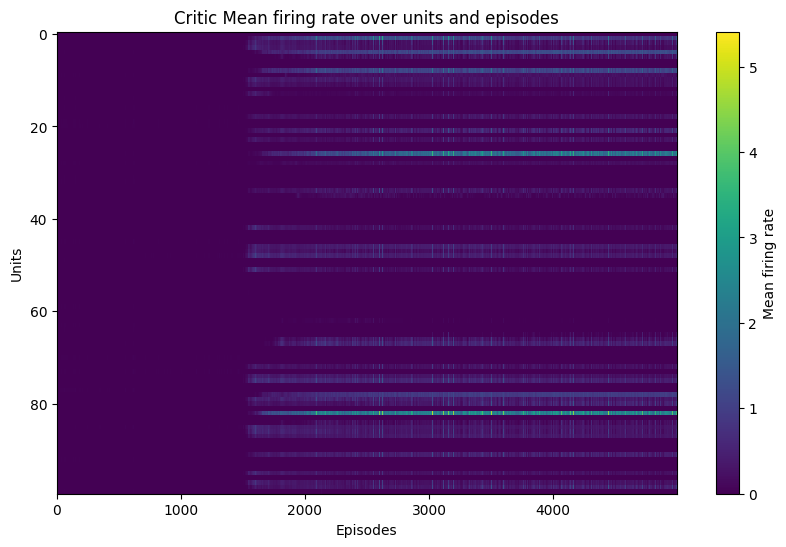

Firing rate plot displayed.

  Plotting Psychometric Curve for this stage...


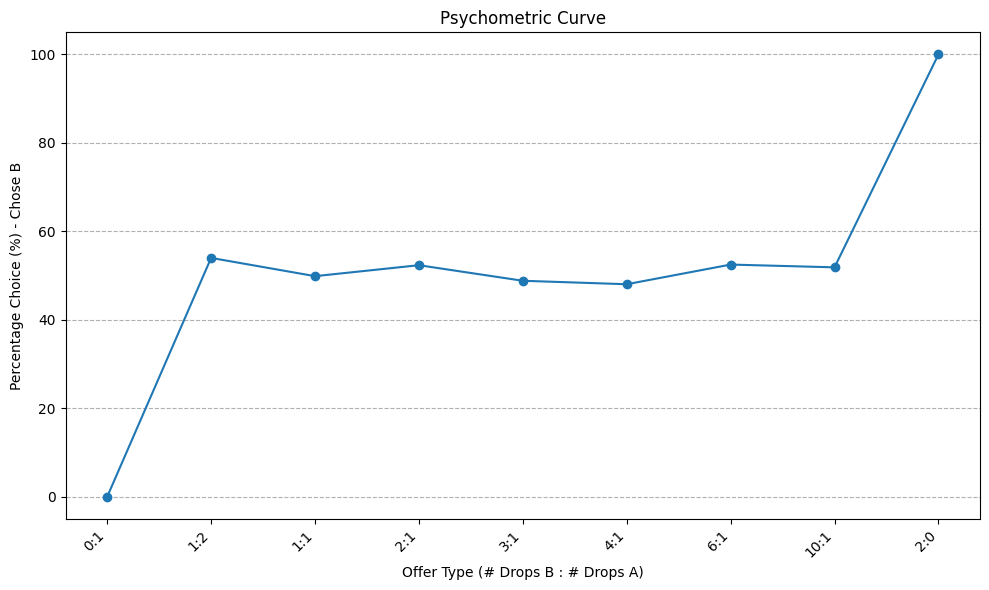

Closing the environment...
Environment closed.


In [9]:
# --- Imports ---
import os
import sys
import gymnasium as gym
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

# --- GPU Configuration ---
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# --- Add Modules directory to Python path ---
module_path = os.path.abspath(os.path.join('.', 'Modules'))

if module_path not in sys.path:
    sys.path.append(module_path)
    print(f"Added '{module_path}' to sys.path")
else:
    print(f"'{module_path}' already in sys.path")

# --- Import custom modules ---
from env_economic_choice import EconomicChoiceEnv
from actor_critic import ActorCriticAgent
from reinforce import train_agent
from helper_functions import plot_metrics, plot_firing_rates, plot_psychometric_curve

# --- Set Random Seeds ---
seed_value = 0
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)

print("Setup Complete.")

# --- Define Paths for Loading/Saving ---
load_weights_path = None
save_weights_path = "saved_models_91/stage_3"

# Ensure save directory exists
save_dir = os.path.dirname(save_weights_path)
if save_dir and not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print(f"Created directory '{save_dir}'")


# --- Training Configuration ---
config = {
    # Environment specific params
    "env_dt_ms": 10,
    "A_to_B_ratio": 2.2,
    "reward_B": 1,
    "abort_penalty": -0.1,
    "input_noise_sigma": 0.0,
    "reward_fixation": 0.01,
    "reward_go_fixation": -0.05,
    "reward_choice_hold": 0.05,
    "duration_params": [50, 30, 70, 70, 30],

    # Agent architecture
    "actor_hidden_size": 100,
    "critic_hidden_size": 100,
    "actor_layers": 1,
    "critic_layers": 1,
    "layer_type": "GRU_modified",
    "actor_prob_connection": 0.1,
    "critic_prob_connection": 1.0,
    "alpha": 0.1,

    # Training hyperparameters
    "actor_lr": 1e-3,
    "critic_lr": 1e-3,
    "num_episodes": 5000,
    "gamma": 0.99,
    "l2_actor": 1e-4,
    "l2_critic": 1e-4,

    # Training process  
    "print_interval": 100,
    "record_history": 1
}

print("Configuration loaded:")
for key, value in config.items():
    print(f"  {key}: {value}")

# --- Environment Setup ---
print("Creating Padoa-Schioppa environment...")
env = EconomicChoiceEnv(
    dt=config["env_dt_ms"],
    A_to_B_ratio=config["A_to_B_ratio"],
    reward_B=config["reward_B"],
    abort_penalty=config["abort_penalty"],
    input_noise_sigma=config["input_noise_sigma"],
    reward_fixation=config["reward_fixation"],
    reward_go_fixation=config["reward_go_fixation"],
    reward_choice_hold=config["reward_choice_hold"],
    duration_params=config["duration_params"]
)

# Get observation and action space sizes from the actual environment instance
obs_size = env.observation_space.shape[0]
act_size = env.action_space.n
print(f"Observation size: {obs_size}, Action size: {act_size}")

initial_obs, initial_info = env.reset(seed=seed_value)
print(f"Environment reset. Initial info: {initial_info}")

# --- Agent Setup ---
print("Initializing Actor-Critic Agent...")
agent = ActorCriticAgent(
    obs_size=obs_size,
    act_size=act_size,
    actor_hidden_size=config["actor_hidden_size"],
    critic_hidden_size=config["critic_hidden_size"],
    actor_layers=config["actor_layers"],
    critic_layers=config["critic_layers"],
    actor_lr=config["actor_lr"],
    critic_lr=config["critic_lr"],
    actor_prob_connection=config["actor_prob_connection"],
    critic_prob_connection=config["critic_prob_connection"],
    layer_type=config["layer_type"],
    alpha=config["alpha"]
)

# Load weights
if load_weights_path:
    print(f"Attempting to load weights from: {load_weights_path}")
    load_successful = agent.load_weights(load_weights_path)
    if not load_successful:
        print(f"WARNING: Failed to load weights. Starting training with initialized weights.")
else:
    print("No weights loaded (load_weights_path is None). Starting from scratch.")

print("Agent Initialized.")

# --- Training ---
print(f"Starting training for {config['num_episodes']} episodes...")

total_rewards_history, actor_loss_history, critic_loss_history, \
actor_firing_rates, critic_firing_rates,  measurements_juices = train_agent(
    env=env,
    agent=agent,
    num_episodes=config["num_episodes"],
    gamma=config["gamma"],
    print_interval=config["print_interval"],
    l2_actor=config["l2_actor"],
    l2_critic=config["l2_critic"],
    record_history=config["record_history"]
)

print("\nTraining finished.")

# Save weights
if save_weights_path:
    print(f"Saving agent weights to: {save_weights_path}")
    agent.save_weights(save_weights_path)
else:
    print("No save path specified (save_weights_path is None). Weights not saved.")

# --- Plot Training Metrics ---
print("Plotting training metrics...")
# Adjust window sizes if needed based on num_episodes
plot_metrics(
    total_rewards_history,
    actor_loss_history,
    critic_loss_history,
    window_1=max(20, config["num_episodes"] // 50),
    window_2=max(50, config["num_episodes"] // 10)
)

print("Metrics plot displayed.")

# --- Plot Firing Rates ---
if actor_firing_rates is not None and critic_firing_rates is not None:
    print("Plotting neuron firing rates...")
    plot_firing_rates(actor_firing_rates, critic_firing_rates)
    print("Firing rate plot displayed.")
# Add checks for partial data as before...
elif actor_firing_rates is not None:
     print("Plotting only Actor firing rates (Critic might be Dense or logging failed)...")
     pass # Add specific plotting if desired
elif critic_firing_rates is not None:
     print("Plotting only Critic firing rates (Actor might be Dense or logging failed)...")
     pass # Add specific plotting if desired
else:
    print("Firing rate data not available (models might be Dense or logging was disabled/failed).")

# --- Plot psychometric curves ---
print("\n  Plotting Psychometric Curve for this stage...")
plot_psychometric_curve(measurements_juices, title=f"Psychometric Curve")

# --- Close the Environment ---
print("Closing the environment...")
env.close()
print("Environment closed.")

### 1 possibility environment

In [ ]:
# --- Imports ---
import os
import sys
import gymnasium as gym
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

# --- GPU Configuration ---
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# --- Add Modules directory to Python path ---
module_path = os.path.abspath(os.path.join('.', 'Modules'))

if module_path not in sys.path:
    sys.path.append(module_path)
    print(f"Added '{module_path}' to sys.path")
else:
    print(f"'{module_path}' already in sys.path")

# --- Import custom modules ---
from env_economic_choice_1A3B import EconomicChoiceEnv
from actor_critic import ActorCriticAgent
from reinforce import train_agent
from helper_functions import plot_metrics, plot_firing_rates, plot_psychometric_curve

# --- Set Random Seeds ---
seed_value = 0
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)

print("Setup Complete.")

# --- Define Paths for Loading/Saving ---
load_weights_path = None
save_weights_path = "saved_models_91/stage_4"

# Ensure save directory exists
save_dir = os.path.dirname(save_weights_path)
if save_dir and not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print(f"Created directory '{save_dir}'")


# --- Training Configuration ---
config = {
    # Environment specific params
    "env_dt_ms": 10,
    "A_to_B_ratio": 2.2,
    "reward_B": 1,
    "abort_penalty": -0.1,
    "input_noise_sigma": 0.0,
    "reward_fixation": 0.01,
    "reward_go_fixation": -0.05,
    "reward_choice_hold": 0.05,
    "duration_params": [50, 30, 70, 70, 30],

    # Agent architecture
    "actor_hidden_size": 100,
    "critic_hidden_size": 100,
    "actor_layers": 1,
    "critic_layers": 1,
    "layer_type": "GRU_modified",
    "actor_prob_connection": 0.1,
    "critic_prob_connection": 1.0,
    "alpha": 0.1,

    # Training hyperparameters
    "actor_lr": 1e-3,
    "critic_lr": 1e-3,
    "num_episodes": 5000,
    "gamma": 0.99,
    "l2_actor": 1e-4,
    "l2_critic": 1e-4,

    # Training process  
    "print_interval": 100,
    "record_history": 1
}

print("Configuration loaded:")
for key, value in config.items():
    print(f"  {key}: {value}")

# --- Environment Setup ---
print("Creating Padoa-Schioppa environment...")
env = EconomicChoiceEnv(
    dt=config["env_dt_ms"],
    A_to_B_ratio=config["A_to_B_ratio"],
    reward_B=config["reward_B"],
    abort_penalty=config["abort_penalty"],
    input_noise_sigma=config["input_noise_sigma"],
    reward_fixation=config["reward_fixation"],
    reward_go_fixation=config["reward_go_fixation"],
    reward_choice_hold=config["reward_choice_hold"],
    duration_params=config["duration_params"]
)

# Get observation and action space sizes from the actual environment instance
obs_size = env.observation_space.shape[0]
act_size = env.action_space.n
print(f"Observation size: {obs_size}, Action size: {act_size}")

initial_obs, initial_info = env.reset(seed=seed_value)
print(f"Environment reset. Initial info: {initial_info}")

# --- Agent Setup ---
print("Initializing Actor-Critic Agent...")
agent = ActorCriticAgent(
    obs_size=obs_size,
    act_size=act_size,
    actor_hidden_size=config["actor_hidden_size"],
    critic_hidden_size=config["critic_hidden_size"],
    actor_layers=config["actor_layers"],
    critic_layers=config["critic_layers"],
    actor_lr=config["actor_lr"],
    critic_lr=config["critic_lr"],
    actor_prob_connection=config["actor_prob_connection"],
    critic_prob_connection=config["critic_prob_connection"],
    layer_type=config["layer_type"],
    alpha=config["alpha"]
)

# Load weights
if load_weights_path:
    print(f"Attempting to load weights from: {load_weights_path}")
    load_successful = agent.load_weights(load_weights_path)
    if not load_successful:
        print(f"WARNING: Failed to load weights. Starting training with initialized weights.")
else:
    print("No weights loaded (load_weights_path is None). Starting from scratch.")

print("Agent Initialized.")

# --- Training ---
print(f"Starting training for {config['num_episodes']} episodes...")

total_rewards_history, actor_loss_history, critic_loss_history, \
actor_firing_rates, critic_firing_rates,  measurements_juices = train_agent(
    env=env,
    agent=agent,
    num_episodes=config["num_episodes"],
    gamma=config["gamma"],
    print_interval=config["print_interval"],
    l2_actor=config["l2_actor"],
    l2_critic=config["l2_critic"],
    record_history=config["record_history"]
)

print("\nTraining finished.")

# Save weights
if save_weights_path:
    print(f"Saving agent weights to: {save_weights_path}")
    agent.save_weights(save_weights_path)
else:
    print("No save path specified (save_weights_path is None). Weights not saved.")

# --- Plot Training Metrics ---
print("Plotting training metrics...")
# Adjust window sizes if needed based on num_episodes
plot_metrics(
    total_rewards_history,
    actor_loss_history,
    critic_loss_history,
    window_1=max(20, config["num_episodes"] // 50),
    window_2=max(50, config["num_episodes"] // 10)
)

print("Metrics plot displayed.")

# --- Plot Firing Rates ---
if actor_firing_rates is not None and critic_firing_rates is not None:
    print("Plotting neuron firing rates...")
    plot_firing_rates(actor_firing_rates, critic_firing_rates)
    print("Firing rate plot displayed.")
# Add checks for partial data as before...
elif actor_firing_rates is not None:
     print("Plotting only Actor firing rates (Critic might be Dense or logging failed)...")
     pass # Add specific plotting if desired
elif critic_firing_rates is not None:
     print("Plotting only Critic firing rates (Actor might be Dense or logging failed)...")
     pass # Add specific plotting if desired
else:
    print("Firing rate data not available (models might be Dense or logging was disabled/failed).")

# --- Plot psychometric curves ---
print("\n  Plotting Psychometric Curve for this stage...")
plot_psychometric_curve(measurements_juices, title=f"Psychometric Curve")

# --- Close the Environment ---
print("Closing the environment...")
env.close()
print("Environment closed.")

2025-04-29 18:15:17.812582: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745943319.727536   12665 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745943320.374492   12665 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745943325.257314   12665 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745943325.257343   12665 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745943325.257345   12665 computation_placer.cc:177] computation placer alr

Added '/mnt/c/Users/imcir/Desktop/CIENCIA DATOS/Segundo cuatrimestre/TFM/Código/Modules' to sys.path
Setup Complete.
Configuration loaded:
  env_dt_ms: 10
  A_to_B_ratio: 2.2
  reward_B: 1
  abort_penalty: -0.1
  input_noise_sigma: 0.0
  reward_fixation: 0.01
  reward_go_fixation: -0.05
  reward_choice_hold: 0.05
  duration_params: [50, 30, 70, 70, 30]
  actor_hidden_size: 100
  critic_hidden_size: 100
  actor_layers: 1
  critic_layers: 1
  layer_type: GRU_modified
  actor_prob_connection: 0.1
  critic_prob_connection: 1.0
  alpha: 0.1
  actor_lr: 0.001
  critic_lr: 0.001
  num_episodes: 5000
  gamma: 0.99
  l2_actor: 0.0001
  l2_critic: 0.0001
  print_interval: 100
  record_history: 1
Creating Padoa-Schioppa environment...
Observation size: 4, Action size: 3
Environment reset. Initial info: {'step': 0, 'epoch': 'fixation', 'juice_LR': ('B', 'A'), 'offer_BA': (3, 1), 'nL': 3, 'nR': 1, 'rL': 3, 'rR': 2.2, 'chosen_action': -1, 'choice_time_step': -1, 'is_correct_choice': None, 'A_to_B_ra

2025-04-29 18:16:45.400881: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


No weights loaded (load_weights_path is None). Starting from scratch.
Agent Initialized.
Starting training for 5000 episodes...
Episode 100	Total Reward: -0.10	State [1. 0. 0. 0.]	Actor Loss: -0.0284	Critic Loss: 0.0009
Episode 200	Total Reward: -0.10	State [1. 0. 0. 0.]	Actor Loss: -0.0203	Critic Loss: 0.0004
Episode 300	Total Reward: -0.10	State [1. 0. 0. 0.]	Actor Loss: -0.0099	Critic Loss: 0.0002
Episode 400	Total Reward: -0.10	State [1. 0. 0. 0.]	Actor Loss: 0.0005	Critic Loss: 0.0001
Episode 500	Total Reward: -0.10	State [1. 0. 0. 0.]	Actor Loss: -0.0198	Critic Loss: 0.0003
Episode 600	Total Reward: -0.10	State [1. 0. 0. 0.]	Actor Loss: -0.0118	Critic Loss: 0.0001
Episode 700	Total Reward: -0.09	State [1. 0. 0. 0.]	Actor Loss: 0.0055	Critic Loss: 0.0001
Episode 800	Total Reward: -0.10	State [1. 0. 0. 0.]	Actor Loss: -0.0167	Critic Loss: 0.0002
Episode 900	Total Reward: -0.10	State [1. 0. 0. 0.]	Actor Loss: -0.0212	Critic Loss: 0.0003
Episode 1000	Total Reward: -0.09	State [1. 0. 

### Economic choice extreme

2025-04-29 19:51:31.849538: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745949093.648626   13437 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745949094.211639   13437 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745949099.158732   13437 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745949099.158763   13437 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745949099.158764   13437 computation_placer.cc:177] computation placer alr

Added '/mnt/c/Users/imcir/Desktop/CIENCIA DATOS/Segundo cuatrimestre/TFM/Código/Modules' to sys.path
Setup Complete.
Configuration loaded:
  env_dt_ms: 10
  A_to_B_ratio: 2.2
  reward_B: 1
  abort_penalty: -0.1
  input_noise_sigma: 0.0
  reward_fixation: 0.01
  reward_go_fixation: -0.05
  reward_choice_hold: 0.05
  duration_params: [50, 30, 70, 70, 30]
  actor_hidden_size: 100
  critic_hidden_size: 100
  actor_layers: 1
  critic_layers: 1
  layer_type: GRU_modified
  actor_prob_connection: 0.1
  critic_prob_connection: 1.0
  alpha: 0.1
  actor_lr: 0.001
  critic_lr: 0.001
  num_episodes: 5000
  gamma: 0.99
  l2_actor: 0.0001
  l2_critic: 0.0001
  print_interval: 100
  record_history: 1
Creating Padoa-Schioppa environment...
Observation size: 4, Action size: 3
Environment reset. Initial info: {'step': 0, 'epoch': 'fixation', 'juice_LR': ('B', 'A'), 'offer_BA': (100, 1), 'nL': 100, 'nR': 1, 'rL': 100, 'rR': 2.2, 'chosen_action': -1, 'choice_time_step': -1, 'is_correct_choice': None, 'A_t

2025-04-29 19:52:35.122523: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


No weights loaded (load_weights_path is None). Starting from scratch.
Agent Initialized.
Starting training for 5000 episodes...
Episode 100	Total Reward: -0.10	State [1. 0. 0. 0.]	Actor Loss: -0.0285	Critic Loss: 0.0008
Episode 200	Total Reward: -0.10	State [1. 0. 0. 0.]	Actor Loss: -0.0205	Critic Loss: 0.0004
Episode 300	Total Reward: -0.10	State [1. 0. 0. 0.]	Actor Loss: -0.0102	Critic Loss: 0.0002
Episode 400	Total Reward: -0.10	State [1. 0. 0. 0.]	Actor Loss: 0.0179	Critic Loss: 0.0002
Episode 500	Total Reward: -0.10	State [1. 0. 0. 0.]	Actor Loss: -0.0176	Critic Loss: 0.0003
Episode 600	Total Reward: -0.10	State [1. 0. 0. 0.]	Actor Loss: -0.0107	Critic Loss: 0.0001
Episode 700	Total Reward: -0.10	State [1. 0. 0. 0.]	Actor Loss: -0.0062	Critic Loss: 0.0001
Episode 800	Total Reward: -0.10	State [1. 0. 0. 0.]	Actor Loss: -0.0167	Critic Loss: 0.0002
Episode 900	Total Reward: -0.10	State [1. 0. 0. 0.]	Actor Loss: -0.0330	Critic Loss: 0.0005
Episode 1000	Total Reward: -0.09	State [1. 0.

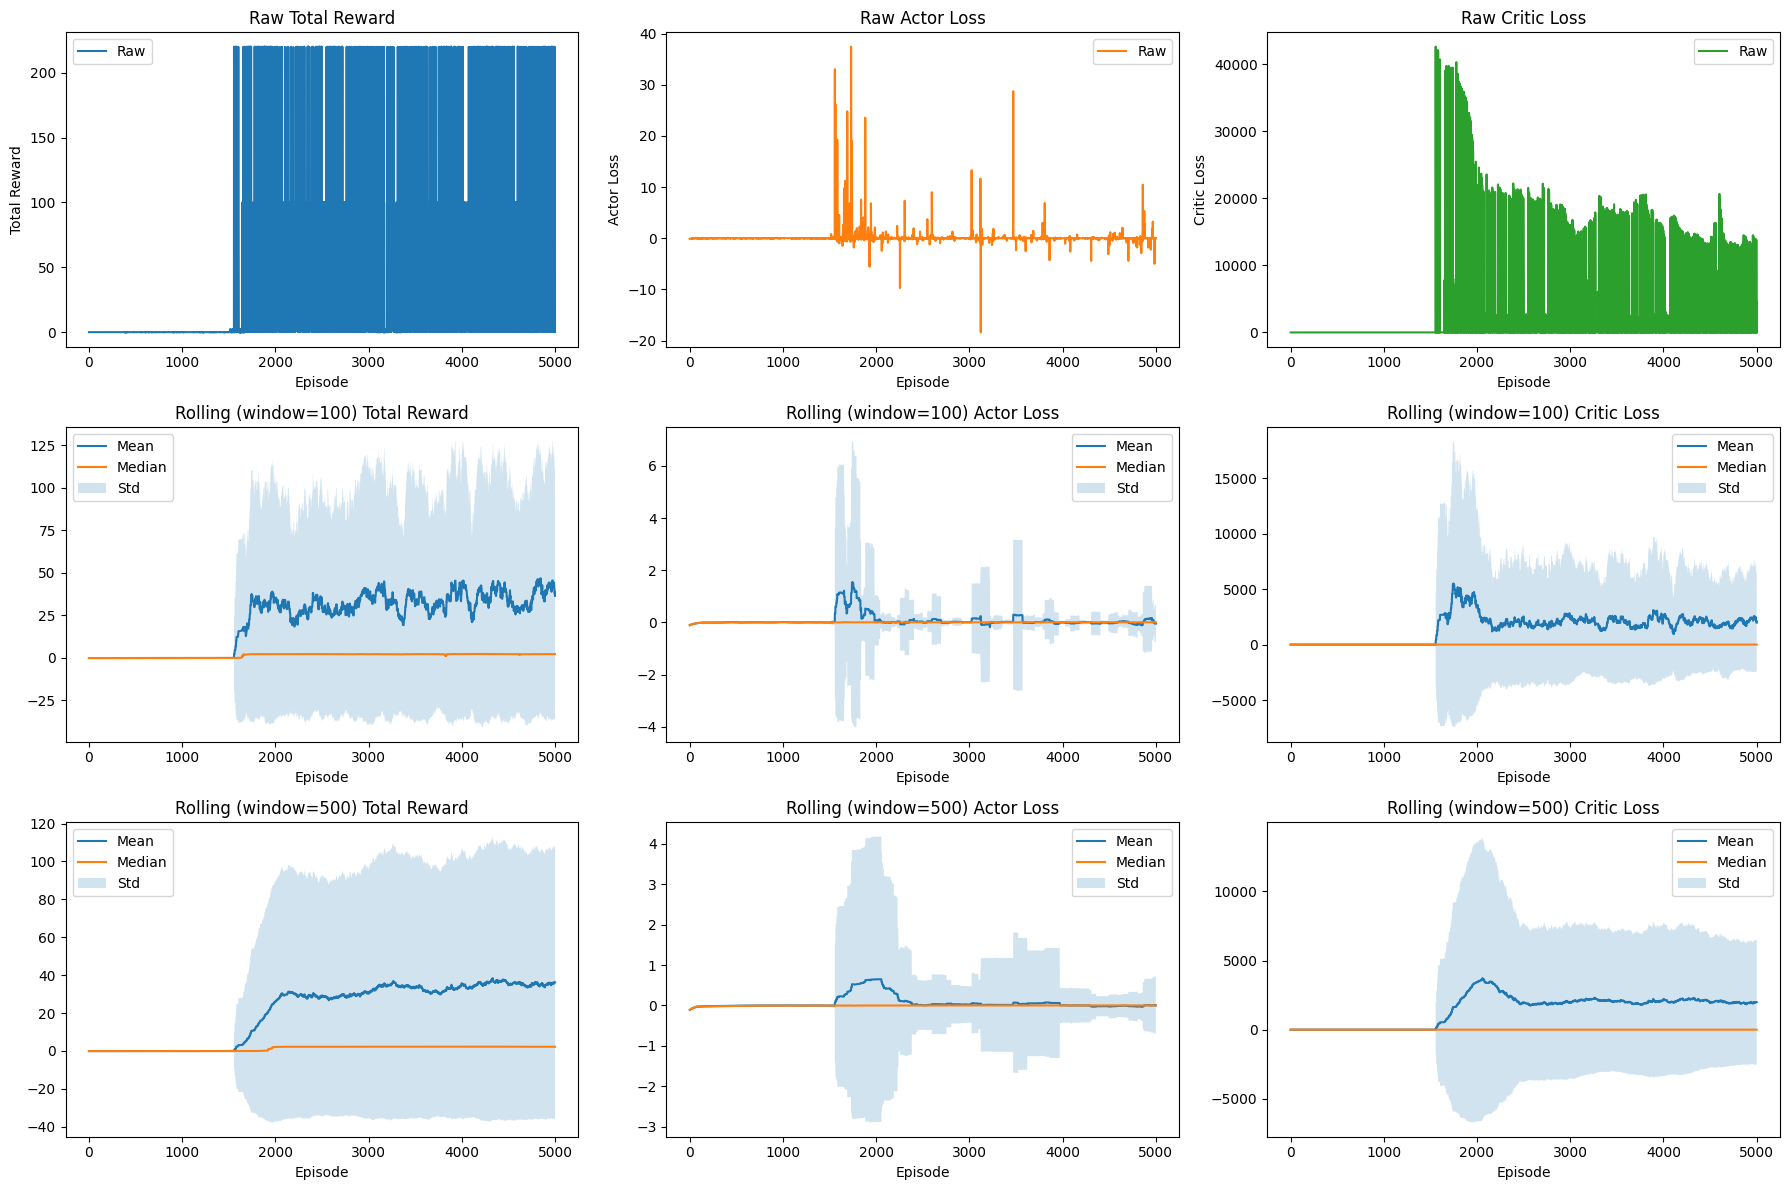

Metrics plot displayed.
Plotting neuron firing rates...


/mnt/c/Users/imcir/Desktop/CIENCIA DATOS/Segundo cuatrimestre/TFM/Código/Modules/helper_functions.py:97: RuntimeWarning: Mean of empty slice
  first_episode = np.nanmean(tensor[:, :, 0], axis=0)
/mnt/c/Users/imcir/Desktop/CIENCIA DATOS/Segundo cuatrimestre/TFM/Código/Modules/helper_functions.py:98: RuntimeWarning: Mean of empty slice
  last_episode = np.nanmean(tensor[:, :, -1], axis=0)


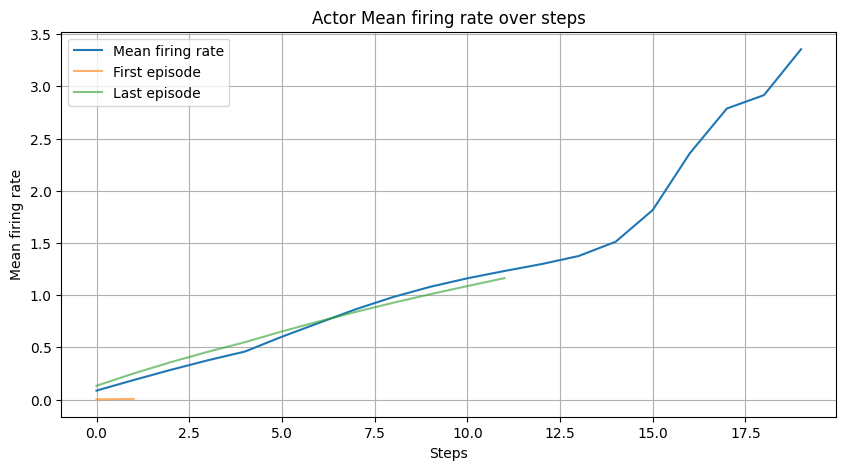

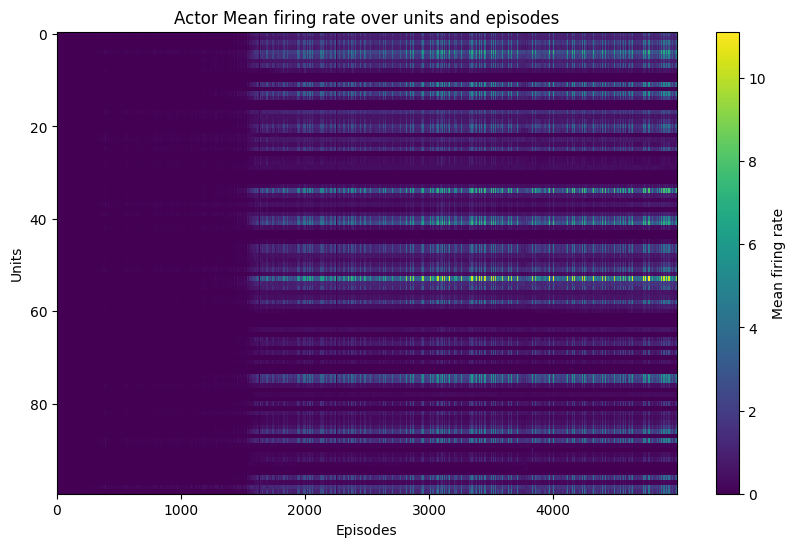

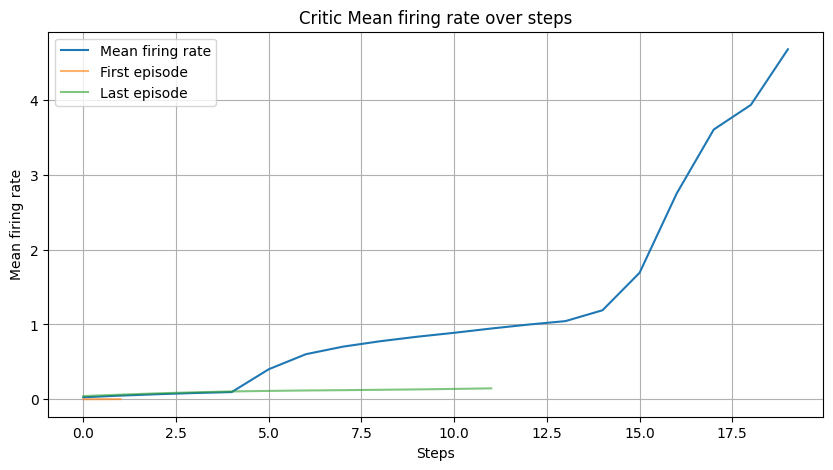

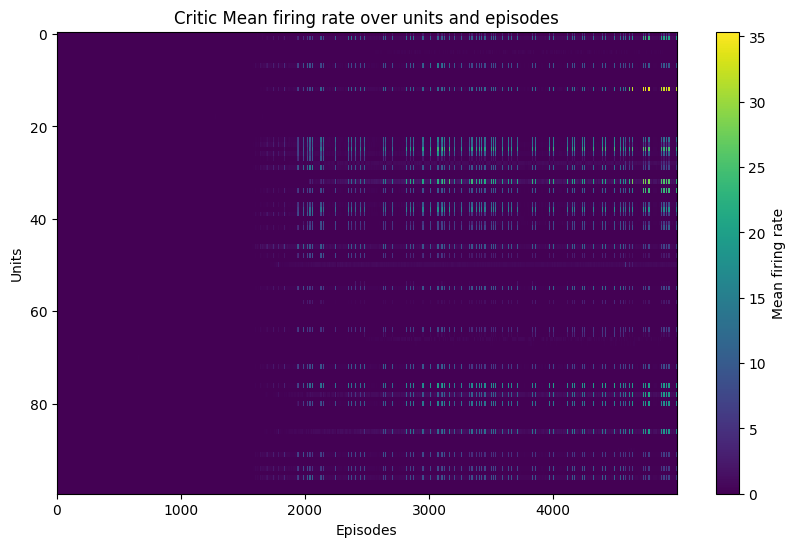

Firing rate plot displayed.

  Plotting Psychometric Curve for this stage...


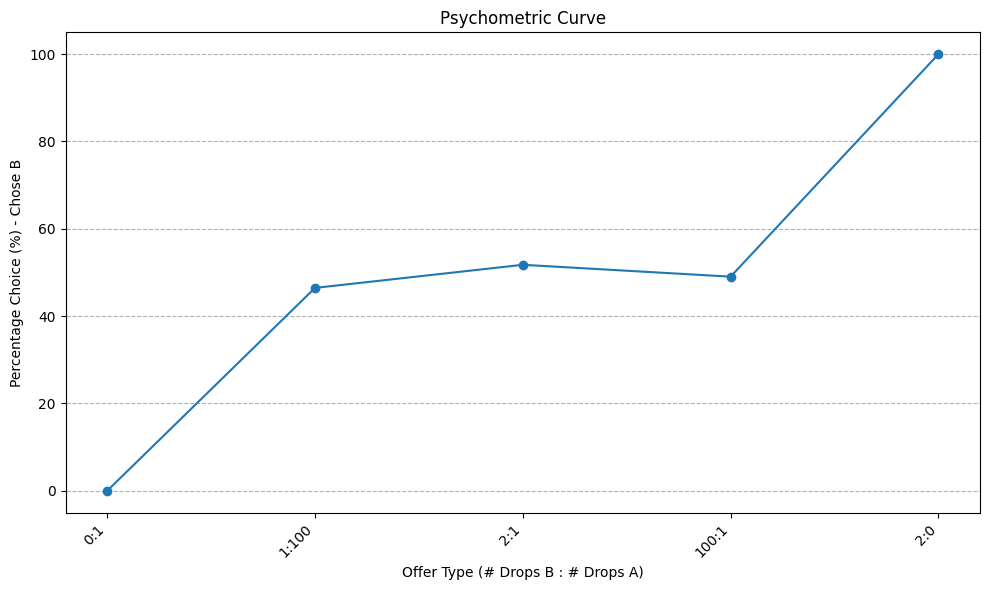

Closing the environment...
Environment closed.


In [1]:
# --- Imports ---
import os
import sys
import gymnasium as gym
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

# --- GPU Configuration ---
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# --- Add Modules directory to Python path ---
module_path = os.path.abspath(os.path.join('.', 'Modules'))

if module_path not in sys.path:
    sys.path.append(module_path)
    print(f"Added '{module_path}' to sys.path")
else:
    print(f"'{module_path}' already in sys.path")

# --- Import custom modules ---
from env_economic_choice_extreme import EconomicChoiceEnv
from actor_critic import ActorCriticAgent
from reinforce import train_agent
from helper_functions import plot_metrics, plot_firing_rates, plot_psychometric_curve

# --- Set Random Seeds ---
seed_value = 0
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)

print("Setup Complete.")

# --- Define Paths for Loading/Saving ---
load_weights_path = None
save_weights_path = "saved_models_91/stage_5"

# Ensure save directory exists
save_dir = os.path.dirname(save_weights_path)
if save_dir and not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print(f"Created directory '{save_dir}'")


# --- Training Configuration ---
config = {
    # Environment specific params
    "env_dt_ms": 10,
    "A_to_B_ratio": 2.2,
    "reward_B": 1,
    "abort_penalty": -0.1,
    "input_noise_sigma": 0.0,
    "reward_fixation": 0.01,
    "reward_go_fixation": -0.05,
    "reward_choice_hold": 0.05,
    "duration_params": [50, 30, 70, 70, 30],

    # Agent architecture
    "actor_hidden_size": 100,
    "critic_hidden_size": 100,
    "actor_layers": 1,
    "critic_layers": 1,
    "layer_type": "GRU_modified",
    "actor_prob_connection": 0.1,
    "critic_prob_connection": 1.0,
    "alpha": 0.1,

    # Training hyperparameters
    "actor_lr": 1e-3,
    "critic_lr": 1e-3,
    "num_episodes": 5000,
    "gamma": 0.99,
    "l2_actor": 1e-4,
    "l2_critic": 1e-4,

    # Training process  
    "print_interval": 100,
    "record_history": 1
}

print("Configuration loaded:")
for key, value in config.items():
    print(f"  {key}: {value}")

# --- Environment Setup ---
print("Creating Padoa-Schioppa environment...")
env = EconomicChoiceEnv(
    dt=config["env_dt_ms"],
    A_to_B_ratio=config["A_to_B_ratio"],
    reward_B=config["reward_B"],
    abort_penalty=config["abort_penalty"],
    input_noise_sigma=config["input_noise_sigma"],
    reward_fixation=config["reward_fixation"],
    reward_go_fixation=config["reward_go_fixation"],
    reward_choice_hold=config["reward_choice_hold"],
    duration_params=config["duration_params"]
)

# Get observation and action space sizes from the actual environment instance
obs_size = env.observation_space.shape[0]
act_size = env.action_space.n
print(f"Observation size: {obs_size}, Action size: {act_size}")

initial_obs, initial_info = env.reset(seed=seed_value)
print(f"Environment reset. Initial info: {initial_info}")

# --- Agent Setup ---
print("Initializing Actor-Critic Agent...")
agent = ActorCriticAgent(
    obs_size=obs_size,
    act_size=act_size,
    actor_hidden_size=config["actor_hidden_size"],
    critic_hidden_size=config["critic_hidden_size"],
    actor_layers=config["actor_layers"],
    critic_layers=config["critic_layers"],
    actor_lr=config["actor_lr"],
    critic_lr=config["critic_lr"],
    actor_prob_connection=config["actor_prob_connection"],
    critic_prob_connection=config["critic_prob_connection"],
    layer_type=config["layer_type"],
    alpha=config["alpha"]
)

# Load weights
if load_weights_path:
    print(f"Attempting to load weights from: {load_weights_path}")
    load_successful = agent.load_weights(load_weights_path)
    if not load_successful:
        print(f"WARNING: Failed to load weights. Starting training with initialized weights.")
else:
    print("No weights loaded (load_weights_path is None). Starting from scratch.")

print("Agent Initialized.")

# --- Training ---
print(f"Starting training for {config['num_episodes']} episodes...")

total_rewards_history, actor_loss_history, critic_loss_history, \
actor_firing_rates, critic_firing_rates,  measurements_juices = train_agent(
    env=env,
    agent=agent,
    num_episodes=config["num_episodes"],
    gamma=config["gamma"],
    print_interval=config["print_interval"],
    l2_actor=config["l2_actor"],
    l2_critic=config["l2_critic"],
    record_history=config["record_history"]
)

print("\nTraining finished.")

# Save weights
if save_weights_path:
    print(f"Saving agent weights to: {save_weights_path}")
    agent.save_weights(save_weights_path)
else:
    print("No save path specified (save_weights_path is None). Weights not saved.")

# --- Plot Training Metrics ---
print("Plotting training metrics...")
# Adjust window sizes if needed based on num_episodes
plot_metrics(
    total_rewards_history,
    actor_loss_history,
    critic_loss_history,
    window_1=max(20, config["num_episodes"] // 50),
    window_2=max(50, config["num_episodes"] // 10)
)

print("Metrics plot displayed.")

# --- Plot Firing Rates ---
if actor_firing_rates is not None and critic_firing_rates is not None:
    print("Plotting neuron firing rates...")
    plot_firing_rates(actor_firing_rates, critic_firing_rates)
    print("Firing rate plot displayed.")
# Add checks for partial data as before...
elif actor_firing_rates is not None:
     print("Plotting only Actor firing rates (Critic might be Dense or logging failed)...")
     pass # Add specific plotting if desired
elif critic_firing_rates is not None:
     print("Plotting only Critic firing rates (Actor might be Dense or logging failed)...")
     pass # Add specific plotting if desired
else:
    print("Firing rate data not available (models might be Dense or logging was disabled/failed).")

# --- Plot psychometric curves ---
print("\n  Plotting Psychometric Curve for this stage...")
plot_psychometric_curve(measurements_juices, title=f"Psychometric Curve")

# --- Close the Environment ---
print("Closing the environment...")
env.close()
print("Environment closed.")